<a href="https://colab.research.google.com/github/kuninethan95/Sentiment_Tracker/blob/main/Copy_of_NLP_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building NLP Sentiment Model

View Only Link: https://drive.google.com/drive/folders/1YOWHabZ4DN8TJxHHcKYWsVESNhch4Dhr?usp=sharing



Include screenshot of how to mount to google drive

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Data/'

In [ ]:


'/content/drive/MyDrive/Colab Notebooks/Data/

Using data from Kaggle to analyze analyze performance of unsupervised machine learning models (VADER + TextBlob). I want to assess their accuracy and evaluate how trustworthy their conclusions are.

https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news

In [ ]:
import pandas as pd

In [ ]:
# Load in Kaggle dataset

url = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/all-data.csv'
df = pd.read_csv(url, encoding='latin1')

In [ ]:
# Rename columns

df.columns = ['sentiment', 'headline']

In [ ]:
df.head()

,sentiment,headline
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [ ]:
# Map sentiment analysis

df['sentiment']=df['sentiment'].map({'neutral':0,
                     'positive':1,
                     'negative':-1})

In [ ]:
df['headline'].drop_duplicates(inplace=True)

In [ ]:
df.head()

,sentiment,headline
0,0,Technopolis plans to develop in stages an area...
1,-1,The international electronic industry company ...
2,1,With the new production plant the company woul...
3,1,According to the company 's updated strategy f...
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


Dataset includes correctly mapped sentiment and raw text in the headline column

## Build VADER Model
- https://github.com/cjhutto/vaderSentiment

In [ ]:
# Download necessary dependencies

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Bring in VADER object

sid = SentimentIntensityAnalyzer()

In [ ]:
# Apply VADER score to each headlines

df['vader'] = df['headline'].apply(lambda headline: sid.polarity_scores(headline))

- VADER contains a polarity score. Polarity score is a measurement of positive to negative [1,-1]
- VADER subjectivity scores returns a positive, netural, negative ,and compound value. Compound value is a mathematical combination of all three other scores


In [ ]:
df.head()

,sentiment,headline,vader
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp..."
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com..."
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp..."
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co..."


In [ ]:
# Unpack neg, neu, pos scores

def unpack_scores(row):
  row['neg'] = row['vader']['neg']
  row['neu'] = row['vader']['neu']
  row['pos'] = row['vader']['pos']
  row['comp'] = row['vader']['compound']
  return row

In [ ]:
df = df.apply(unpack_scores, axis=1)

In [ ]:
df.head()

,sentiment,headline,vader,neg,neu,pos,comp
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485


Confirm that all 4 scores appear in the dataframe

## Build Blob Model
- https://textblob.readthedocs.io/en/dev/

In [ ]:
from textblob import TextBlob

- Textblob contains two scores: subjectivity and polarity
- Subjectivity [0,1] determines the truthfulness of a statement (0 objective, 1 subjectvie)
- Polarity [-1,1] determines the postive, negative, or neutral sentiment of a text

In [ ]:
# Using polarity score as opposed to subjectivity score

df['blob'] = df['headline'].apply(lambda headline: TextBlob(headline).polarity)

In [ ]:
df.head()

,sentiment,headline,vader,neg,neu,pos,comp,blob
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960,0.083333
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555,-0.064802
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705,0.000000
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485,0.500000


- Confirm blob scores appear

## Find Optimal Threshold Values
- VADER + TextBlob documentation does not specify a cutoff for positive, neutral, or negative sentiment
- Experiment with different cutoff values for determining optimal threshold value for pos, neg, neu
  - ie. -1 thru -0.15 is neg, -0.15 to 0.15 is neu, 0.15 to 1 is pos

In [ ]:
# Pos, neg, neu sentiment based on input threshold
# Begin by testing 0.15

def create_sentiment_neutral(x, thresh=0.15):
  if x > thresh:
    return 1
  elif x < -1*thresh:
    return -1
  else:
    return 0

In [ ]:
# Make sure function operates correctly

df['comp'].map(lambda x: create_sentiment_neutral(x,thresh=0.15))

0      -1
1       0
2       1
3       1
4       1
       ..
4840   -1
4841    0
4842    1
4843    1
4844    0
Name: comp, Length: 4845, dtype: int64

In [ ]:
df.head()

,sentiment,headline,vader,neg,neu,pos,comp,blob
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960,0.083333
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555,-0.064802
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705,0.000000
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485,0.500000


Values appear

- Given that there is no set threshold for determing sentiment, try a threshold score of 0 to 0.8
- Using accuracy score to find optimal threshold for pos, neg, neu
- Find tradeoff between accuracy score and misclassifying values as neutral that are pos/neg

In [ ]:
# Tet out various threshold values

import numpy as np
from sklearn.metrics import accuracy_score, f1_score
thresh_vals = np.linspace(0, 0.8, 30)

In [ ]:
# Apply to VADER

accuracy_scores_vader = {}
for t in thresh_vals:
  df[f'sent_score{t}'] = df['comp'].map(lambda x: create_sentiment_neutral(x, thresh=t))
  acc = accuracy_score(df['sentiment'], df[f'sent_score{t}'])
  f1 = f1_score(df['sentiment'], df[f'sent_score{t}'], average='weighted')
  accuracy_scores_vader[t]=[acc, f1]
  df.drop(columns=f'sent_score{t}', inplace=True)
# df.rename(columns={'sent_score0.0':'sent_score'}, inplace=True)

In [ ]:
df.head()

,sentiment,headline,vader,neg,neu,pos,comp,blob
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960,0.083333
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555,-0.064802
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705,0.000000
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485,0.500000


In [ ]:
thresh_scores_vader = pd.DataFrame(accuracy_scores_vader).T

In [ ]:
thresh_scores_vader.rename(columns={0:'Accuracy', 1:'F1'}, inplace=True)
thresh_scores_vader.reset_index(inplace=True)
thresh_scores_vader.rename(columns={'index': 'threshold_val'}, inplace=True)

In [ ]:
thresh_scores_vader

,threshold_val,Accuracy,F1
0,0.000000,0.542828,0.549479
1,0.027586,0.543034,0.548971
2,0.055172,0.544479,0.550345
3,0.082759,0.547781,0.553245
4,0.110345,0.549845,0.555381
5,0.137931,0.550258,0.554564
6,0.165517,0.546543,0.549240
7,0.193103,0.550464,0.552896
8,0.220690,0.554180,0.556355
9,0.248276,0.559959,0.561187


- Optimal vader thresh = 0.30
- Based on F1 score optimization
- Opted for lower accuracy score because I do not want to misclassify an excessive amount of pos/neg sentiments as neutral

In [ ]:
# testing thresholds for Blob

accuracy_scores_blob = {}
for t in thresh_vals:
  df[f'sent_score{t}'] = df['blob'].map(lambda x: create_sentiment_neutral(x, thresh=t))
  acc = accuracy_score(df['sentiment'], df[f'sent_score{t}'])
  f1 = f1_score(df['sentiment'], df[f'sent_score{t}'], average='weighted')
  accuracy_scores_blob[t]=[acc, f1]
  df.drop(columns=f'sent_score{t}', inplace=True)

In [ ]:
thresh_scores_blob = pd.DataFrame(accuracy_scores_blob).T

In [ ]:
thresh_scores_blob.rename(columns={0:'Accuracy', 1:'F1'}, inplace=True)

In [ ]:
thresh_scores_blob.reset_index(inplace=True)
thresh_scores_blob.rename(columns={'index': 'threshold_val'}, inplace=True)

In [ ]:
thresh_scores_blob

,threshold_val,Accuracy,F1
0,0.000000,0.491022,0.500018
1,0.027586,0.494118,0.501431
2,0.055172,0.511042,0.512568
3,0.082759,0.522601,0.518851
4,0.110345,0.547575,0.532718
5,0.137931,0.566357,0.540672
6,0.165517,0.565738,0.531831
7,0.193103,0.575645,0.534037
8,0.220690,0.583488,0.527446
9,0.248276,0.585759,0.525343


- Optimal Blob thresh = 0.14
- Based on F1 score optimization
- Opted for lower accuracy score because I do not want to misclassify an excessive amount of pos/neg sentiments as neutral

In [ ]:
# Apply VADER and Blob scores based on thresholds

df['comp_abs']=df['comp'].map(lambda x: create_sentiment_neutral(x))
df['blob_abs']=df['blob'].map(lambda x: create_sentiment_neutral(x))

In [ ]:
df.head()

,sentiment,headline,vader,neg,neu,pos,comp,blob,comp_abs,blob_abs
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960,0.083333,-1,0
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000,0,0
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555,-0.064802,1,0
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705,0.000000,1,0
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485,0.500000,1,1


## Reconcile difference between VADER and Blob conclusions
- Determine the best rules for handling difference between VADER + TextBlob

In [ ]:
# Column to show where VADER and Blob agree
# Column to show where VADER and Blob differ

df['same'] = (df['comp_abs']==df['blob_abs'])
df['c_b'] = df['comp']-df['blob']

In [ ]:
# Column to show where VADER and Blob disagree
# DF where VADER and blob agree

df_diff = df[df['same']!=True].copy()
df_same = df[df['same']==True].copy()

In [ ]:
# Show accuracy of VADER + TextBlob when they agree

same_blob_acc = accuracy_score(df_same['sentiment'], df_same['blob_abs'])
same_vader_acc = accuracy_score(df_same['sentiment'], df_same['comp_abs'])
print(f"Same: Blob Acc > {same_blob_acc}")
print(f"Same: Vader Acc > {same_vader_acc}")

Same: Blob Acc > 0.6729585556011489
Same: Vader Acc > 0.6729585556011489


When the scores are the same, of course it doesn't matter which model is chosen

In [ ]:
# Show accuracy of VADER + TextBlob when they differ

diff_blob_acc = accuracy_score(df_diff['sentiment'], df_diff['blob_abs'])
diff_vader_acc = accuracy_score(df_diff['sentiment'], df_diff['comp_abs'])
print(f"Diff: Blob Acc > {diff_blob_acc}")
print(f"Diff: Vader Acc > {diff_vader_acc}")

Diff: Blob Acc > 0.4634551495016611
Diff: Vader Acc > 0.4260797342192691


- When the scores are different, Vader compound is a more accurate scoring method
- Scores are less accurate when VADER and Blob disagree

In [ ]:
print('---------BASELINE---------')
print(df['sentiment'].value_counts(1))
print('---------SAME---------')
print(df_same['sentiment'].value_counts(1))
print('---------DIFFERENT---------')
print(df_diff['sentiment'].value_counts(1))

---------BASELINE---------
 0    0.594014
 1    0.281321
-1    0.124665
Name: sentiment, dtype: float64
---------SAME---------
 0    0.668034
 1    0.240460
-1    0.091506
Name: sentiment, dtype: float64
---------DIFFERENT---------
 0    0.519103
 1    0.322674
-1    0.158223
Name: sentiment, dtype: float64


- When VADER and Blob match -> mainly neutral sentiment
- When VADER and Blob differ -> mainly pos/neg sentiment compared to neutral

In [ ]:
# Check overall accuracy of VADER vs. Blob

print(accuracy_score(df['sentiment'], df['comp_abs']))
print(accuracy_score(df['sentiment'], df['blob_abs']))

0.5502579979360165
0.5688338493292053


VADER is more accurate than TextBlob

## Methodology for handling large differences in concensus
- As a not: c_b represents the difference between the compound VADER score and the TextBlob score
  - Measures how much they differ

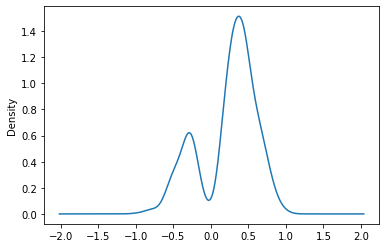

In [ ]:
# Distribution of differences

df_diff['c_b'].plot(kind='kde')

Most of the density is between -0.5 & 0.5

In [ ]:
# Summary of distribution

df_diff['c_b'].describe()

count    2408.000000
mean        0.235155
std         0.377798
min        -1.001900
25%         0.090600
50%         0.318200
75%         0.492252
max         1.024067
Name: c_b, dtype: float64

- Largest disparity betweeen compound and Blob score on the negative side is -1.001
- Largest disparity between compound and Blob score on the postive side is 1.02

In [ ]:
# High CB score = VADER > Blob
# Low CB score = VADER < Blob

df_c_b_lower = df_diff[df_diff['c_b']<=df_diff['c_b'].quantile(0.10)]
df_c_b_upper = df_diff[df_diff['c_b']>=df_diff['c_b'].quantile(0.90)]
print(len(df_c_b_lower))
print(len(df_c_b_upper))

241
248


- Lower represents when compound minus blob is very small (bottom 10% of values)
- Upper represents when compound minus blob is very large (top 90% of values)
- Note: all of these values are where blob and vader disagree

In [ ]:
# Inspect sentiment when they disagree at extreme levels (top 90%/bottom 10%)

print('-----------LOWER-----------')
print(df_c_b_lower['sentiment'].value_counts(1))
print('-----------UPPER-----------')
print(df_c_b_upper['sentiment'].value_counts(1))

-----------LOWER-----------
 0    0.464730
-1    0.315353
 1    0.219917
Name: sentiment, dtype: float64
-----------UPPER-----------
 1    0.483871
 0    0.383065
-1    0.133065
Name: sentiment, dtype: float64


When VADER-Blob is very small, tends to be neutral sentiment

When VADER-Blob is very large, tends to be positive sentiment

In [ ]:
# Observing where VADER-Blob is small

pd.set_option('display.max_colwidth', None)
df_c_b_lower.sort_values(by='c_b').head(10)

,sentiment,headline,vader,neg,neu,pos,comp,blob,comp_abs,blob_abs,same,c_b
713,1,"The stock price rose 70.0 ores or 0.9 % to close at SEK77 .65 , ending a two-day streak of losses .","{'neg': 0.137, 'neu': 0.863, 'pos': 0.0, 'compound': -0.4019}",0.137,0.863,0.000,-0.4019,0.60,-1,1,False,-1.0019
4237,0,SWOT analysis is just one method of categorization and has its own weaknesses .,"{'neg': 0.172, 'neu': 0.828, 'pos': 0.0, 'compound': -0.3612}",0.172,0.828,0.000,-0.3612,0.60,-1,1,False,-0.9612
718,1,Operating result including non-recurring items rose to EUR 146mn from a loss of EUR 267mn in 2009 .,"{'neg': 0.133, 'neu': 0.867, 'pos': 0.0, 'compound': -0.3182}",0.133,0.867,0.000,-0.3182,0.60,-1,1,False,-0.9182
4808,0,Pentik+Æinen emphasises that the most of the internet contents media houses provide can not be free forever .,"{'neg': 0.144, 'neu': 0.856, 'pos': 0.0, 'compound': -0.4023}",0.144,0.856,0.000,-0.4023,0.45,-1,1,False,-0.8523
4544,0,"The chain has been trying to cut its own costs , pressuring vendors such as fitness equipment manufacturer Precor to slash prices .","{'neg': 0.257, 'neu': 0.661, 'pos': 0.082, 'compound': -0.5423}",0.257,0.661,0.082,-0.5423,0.30,-1,1,False,-0.8423
4521,1,1 Block lamp Harri Koskinen 's light was introduced in 1996 and has been a bestseller ever since .,"{'neg': 0.162, 'neu': 0.838, 'pos': 0.0, 'compound': -0.4404}",0.162,0.838,0.000,-0.4404,0.40,-1,1,False,-0.8404
2990,0,"Jeder Beta-Tester erh+Ælt kostenlos sechs Monate lang Updates und hat laut eigener Aussage die M+¦glichkeit , die finale Version zu beeinflussen .","{'neg': 0.302, 'neu': 0.698, 'pos': 0.0, 'compound': -0.8316}",0.302,0.698,0.000,-0.8316,0.00,-1,0,False,-0.8316
4420,-1,Relations with the City have been further damaged by comments from Mr Ashley criticising City investors and analysts as `` cry babies '' .,"{'neg': 0.303, 'neu': 0.697, 'pos': 0.0, 'compound': -0.8271}",0.303,0.697,0.000,-0.8271,0.00,-1,0,False,-0.8271
1954,0,"Swedish telco TeliaSonera is teaming up with Friends , a Swedish organization against bullying , to fight bullying of children and teenagers via electronic channels .","{'neg': 0.33, 'neu': 0.571, 'pos': 0.098, 'compound': -0.8074}",0.330,0.571,0.098,-0.8074,0.00,-1,0,False,-0.8074
2173,1,"Pre-tax loss totaled EUR 0.3 mn , compared to a loss of EUR 2.2 mn in the first quarter of 2005 .","{'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.5574}",0.213,0.787,0.000,-0.5574,0.25,-1,1,False,-0.8074


- Generally tend to agree with VADER more, there are confounding positive and negative words 
- Add wordcloud here


In [ ]:
# Observing where VADER-Blob is large

pd.set_option('display.max_colwidth', None)
df_c_b_upper.sort_values(by='c_b', ascending=False).head(10)

,sentiment,headline,vader,neg,neu,pos,comp,blob,comp_abs,blob_abs,same,c_b
21,1,"MegaFon 's subscriber base increased 16.1 % in 2009 to 50.5 million users as of December 31 , while its market share by the number of customers amounted to 24 % as of late 2009 , up from 23 % as of late 2008 , according to TeliaSonera estimates .","{'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'compound': 0.5574}",0.000,0.877,0.123,0.5574,-0.466667,1,-1,False,1.024067
4582,0,"Operating profit for the six-month period decreased from EUR111 .9 m , while sales increased from EUR1 ,275 m , as compared to the corresponding period in 2006 .","{'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'compound': 0.6124}",0.000,0.815,0.185,0.6124,-0.400000,1,-1,False,1.012400
1386,0,"The Hayward , Calif.-based target designs active , casual and dress footwear , as well as boots and sandals .","{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'compound': 0.6808}",0.000,0.663,0.337,0.6808,-0.316667,1,-1,False,0.997467
3836,0,The enterprise value of Maritim Food AS has been determined as approximately EUR15m .,"{'neg': 0.0, 'neu': 0.696, 'pos': 0.304, 'compound': 0.5859}",0.000,0.696,0.304,0.5859,-0.400000,1,-1,False,0.985900
2368,0,"About 72 % of Evraz Group shares are owned by Lanebrook , whose beneficiaries , on the one hand , are Millhouse , the holding company for the assets of billionaire Roman Abramovich and his business partners 50 % ; and Evraz executives Alexander Abramov and Alexander Frolov 50 % , on the other .","{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.836}",0.000,0.806,0.194,0.8360,-0.125000,1,0,False,0.961000
303,1,"There has been some recovery of the base metals prices and increased demand for metals in China , however .","{'neg': 0.077, 'neu': 0.816, 'pos': 0.107, 'compound': 0.1531}",0.077,0.816,0.107,0.1531,-0.800000,1,-1,False,0.953100
1995,0,"As a result of the cancellation , the maximum increase of Citycon 's share capital on the basis of the convertible bonds decreased from EUR 23,383,927.80 to EUR 22,901,784.75 .","{'neg': 0.0, 'neu': 0.847, 'pos': 0.153, 'compound': 0.5423}",0.000,0.847,0.153,0.5423,-0.400000,1,-1,False,0.942300
4458,1,"efficiency improvement measures 20 January 2010 - Finnish stationery and gift retailer Tiimari HEL : TII1V said today that it will continue to improve its operational efficiency , by focusing on its profitable core operations .","{'neg': 0.0, 'neu': 0.609, 'pos': 0.391, 'compound': 0.9403}",0.000,0.609,0.391,0.9403,0.000000,1,0,False,0.940300
4471,1,"The long-standing partnership and commitment enable both parties to develop their respective operations , and ESL Shipping will also have the opportunity to update its fleet and improve its efficiency .","{'neg': 0.0, 'neu': 0.585, 'pos': 0.415, 'compound': 0.936}",0.000,0.585,0.415,0.9360,0.000000,1,0,False,0.936000
3384,0,"The transaction is subject to a final agreement between the parties , approvals of their decision-making bodies and approval by the Finnish Competition Authority .","{'neg': 0.0, 'neu': 0.636, 'pos': 0.364, 'compound': 0.8519}",0.000,0.636,0.364,0.8519,-0.083333,1,0,False,0.935233


Both have difficulty with neutral values

Add wordcloud here

## Determine Optimal Reconcilliation Rules
- Create rules based approach for optimizing accuracy score given a TextBlob and VADER score

In [ ]:
# Determine optimal classification value based on different thresholds
# Potentially add functionality for greater/lesser thresholds

def classification_rules(df):

  # if blob and vader agree use their agreed upon sentiment
  if (df['comp_abs'] == df['blob_abs']):
    return df['comp_abs']
  
  # if they differ - do the following
  else:
    if df['c_b']<-0.13:
      return df['comp_abs']
    elif df['c_b']>0.71:
      return df['comp_abs']
    else:
      return df['comp_abs']

Add apply here with different threshold values

In [ ]:
# Apply sentiment based on thresholds

df['rules_sent'] = df.apply(classification_rules, axis=1)

In [ ]:
pd.reset_option('^display.', silent=True)
df.head()

,sentiment,headline,vader,neg,neu,pos,comp,blob,comp_abs,blob_abs,same,c_b,rules_sent
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960,0.083333,-1,0,False,-0.379333,-1
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000,0,0,True,0.000000,0
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555,-0.064802,1,0,False,0.920302,1
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705,0.000000,1,0,False,0.670500,1
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485,0.500000,1,1,True,-0.151500,1


In [ ]:
# Calculate accurate score

accuracy_score(df['sentiment'], df['rules_sent'])

0.5502579979360165

- Baseline score of 55%, compared to a random guess of 33%

In [ ]:
df.head()

,sentiment,headline,vader,neg,neu,pos,comp,blob,comp_abs,blob_abs,same,c_b,rules_sent
0,0,Technopolis plans to develop in stages an area...,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",0.073,0.927,0.000,-0.2960,0.083333,-1,0,False,-0.379333,-1
1,-1,The international electronic industry company ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.000000,0,0,True,0.000000,0
2,1,With the new production plant the company woul...,"{'neg': 0.038, 'neu': 0.66, 'pos': 0.302, 'com...",0.038,0.660,0.302,0.8555,-0.064802,1,0,False,0.920302,1
3,1,According to the company 's updated strategy f...,"{'neg': 0.0, 'neu': 0.853, 'pos': 0.147, 'comp...",0.000,0.853,0.147,0.6705,0.000000,1,0,False,0.670500,1
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"{'neg': 0.148, 'neu': 0.657, 'pos': 0.195, 'co...",0.148,0.657,0.195,0.3485,0.500000,1,1,True,-0.151500,1


In [ ]:
# Testing different outcomes for lower threshold 

print(accuracy_score(df_c_b_lower['sentiment'], df_c_b_lower['blob_abs']))
print(accuracy_score(df_c_b_lower['sentiment'], df_c_b_lower['comp_abs']))
print(accuracy_score(df_c_b_lower['sentiment'], np.zeros(shape=len(df_c_b_lower))))
print(accuracy_score(df_c_b_lower['sentiment'], np.ones(shape=len(df_c_b_lower))))
print(accuracy_score(df_c_b_lower['sentiment'], np.full(shape=len(df_c_b_lower), fill_value=-1)))


0.37344398340248963
0.46473029045643155
0.46473029045643155
0.21991701244813278
0.3153526970954357


Accuracy score is highest for VADER analysis

In [ ]:
print(accuracy_score(df_c_b_upper['sentiment'], df_c_b_upper['blob_abs']))
print(accuracy_score(df_c_b_upper['sentiment'], df_c_b_upper['comp_abs']))
print(accuracy_score(df_c_b_upper['sentiment'], np.zeros(shape=len(df_c_b_upper))))
print(accuracy_score(df_c_b_upper['sentiment'], np.ones(shape=len(df_c_b_upper))))
print(accuracy_score(df_c_b_upper['sentiment'], np.full(shape=len(df_c_b_upper), fill_value=-1)))

0.375
0.4879032258064516
0.38306451612903225
0.4838709677419355
0.13306451612903225


Accuracy score is highest for VADER analysis

When VADER and Blob at different quantiles, try imputing a score of -1, 0, 1, VADER or TextBlob

In [ ]:
# Test out blob, VADER, 0, 1, -1 for various thresholds of cb values

lower_ = np.linspace(0,0.15,16)
upper_ = np.linspace(stop=0.85,start=1.00,num=16)
lower_upper = zip(lower_, upper_)
thresh_vals = {}
for lower, upper in lower_upper:
  df_c_b_lower = df[df['c_b']<=df['c_b'].quantile(lower)]
  df_c_b_upper = df[df['c_b']>=df['c_b'].quantile(upper)]
  blob_acc_upper = accuracy_score(df_c_b_upper['sentiment'], df_c_b_upper['blob_abs'])
  blob_acc_lower = accuracy_score(df_c_b_lower['sentiment'], df_c_b_lower['blob_abs'])
  vader_acc_upper = accuracy_score(df_c_b_upper['sentiment'], df_c_b_upper['comp_abs'])
  vader_acc_lower = accuracy_score(df_c_b_lower['sentiment'], df_c_b_lower['comp_abs'])
  upper_zeros = accuracy_score(df_c_b_upper['sentiment'], np.zeros(shape=len(df_c_b_upper)))
  lower_zeros = accuracy_score(df_c_b_lower['sentiment'], np.zeros(shape=len(df_c_b_lower)))
  upper_ones = accuracy_score(df_c_b_upper['sentiment'], np.ones(shape=len(df_c_b_upper)))
  lower_ones = accuracy_score(df_c_b_lower['sentiment'], np.ones(shape=len(df_c_b_lower)))
  upper_neg = accuracy_score(df_c_b_upper['sentiment'], np.full(shape=len(df_c_b_upper), fill_value=-1))
  lower_neg = accuracy_score(df_c_b_lower['sentiment'], np.full(shape=len(df_c_b_lower), fill_value=-1))



  thresh_vals[(upper, lower)] = [blob_acc_upper, blob_acc_lower, vader_acc_upper, vader_acc_lower,
                                 upper_zeros, lower_zeros, upper_ones, lower_ones, upper_neg, lower_neg]


In [ ]:
df_fresh = pd.DataFrame(thresh_vals).T

In [ ]:
df_fresh.columns = ['blob_upper', 'blob_lower', 'vader_upper', 'vader_lower', 'upper_0',
                 'lower_0', 'upper_1', 'lower_1', 'upper_neg', 'lower_neg']

In [ ]:
# Best performer is 0.97 VADER
df_fresh.iloc[:,[0,2,4,6,8]]

,,blob_upper,vader_upper,upper_0,upper_1,upper_neg
1.00,0.00,0.000000,1.000000,0.000000,1.000000,0.000000
0.99,0.01,0.464286,0.375000,0.285714,0.375000,0.339286
0.98,0.02,0.355769,0.490385,0.317308,0.480769,0.201923
0.97,0.03,0.308219,0.520548,0.308219,0.513699,0.178082
0.96,0.04,0.371981,0.483092,0.367150,0.478261,0.154589
0.95,0.05,0.366255,0.497942,0.370370,0.493827,0.135802
0.94,0.06,0.389262,0.489933,0.385906,0.486577,0.127517
0.93,0.07,0.385294,0.497059,0.385294,0.494118,0.120588
0.92,0.08,0.415816,0.466837,0.377551,0.464286,0.158163
0.91,0.09,0.417431,0.467890,0.392202,0.465596,0.142202


On upper threshold - VADER 0.97 is the highest performer

In [ ]:
# Best performer is 0.15 VADER
df_fresh.iloc[:,[1,3,5,7,9]]

,,blob_lower,vader_lower,lower_0,lower_1,lower_neg
1.00,0.00,1.000000,0.000000,0.000000,1.000000,0.000000
0.99,0.01,0.469388,0.285714,0.448980,0.326531,0.224490
0.98,0.02,0.353982,0.460177,0.433628,0.265487,0.300885
0.97,0.03,0.363014,0.445205,0.452055,0.226027,0.321918
0.96,0.04,0.350515,0.453608,0.427835,0.226804,0.345361
0.95,0.05,0.372951,0.479508,0.467213,0.221311,0.311475
0.94,0.06,0.377419,0.441935,0.441935,0.251613,0.306452
0.93,0.07,0.395349,0.436047,0.433140,0.279070,0.287791
0.92,0.08,0.438776,0.477041,0.474490,0.244898,0.280612
0.91,0.09,0.440367,0.481651,0.458716,0.245413,0.295872


On lower threshold - VADER 0.15 is the highest performer

In [ ]:
# Threshold values

print(df['c_b'].quantile(0.15))
print(df['c_b'].quantile(0.97))

-0.13636363636363635
0.710968


# Extract, Transform, Load Data
- Performing initial test with Apple

In [ ]:
# Function to read in csv and exclude 'bad sources'

def read_in_data(filepath):
    df = pd.read_csv(filepath)
    df.drop(columns='Unnamed: 0', inplace=True)
    df = df[~df['source2'].isin(bad_sources)].copy()
    return df

Manually checked out 500+ media sources and eliminated sources that were either advertisements or provided irrelevant information

In [ ]:
# Sources to exlude

bad_sources = ['LatestLY', 'iMore', 'Phandroid - News for Android', 'Internet', 'AnandTech', 'Justcreative.com',
      'Raywenderlich.com', 'Lifehacker Australia', 'News18', 'Zee Business', 'Geeky Gadgets', 'Business Wire',
      'Digital Information World', 'Madshrimps.be', 'Theinventory.com', 'Ozbargain.com.au', 'Www.bgr.in',
      "Paul Tan's Automotive News", 'Livemint', 'Todayifoundout.com', 'Hotukdeals.com', 'Thefutoncritic.com',
      'Applelinkage.com', 'Worldsoccertalk.com', '9to5Toys', 'Torrentfreak.com', 'Slickdeals.net',
      'Rock Paper Shotgun', 'Idownloadblog.com', 'Justinobeirne.com', 'Everydaycarry.com', 'Ars Technica',
      'Intheknow.com', 'Yanko Design', 'Lefsetz.com', 'Android Community', '/FILM', 'Droid Life',
      'Moneysavingmom.com', 'WDVM 25', 'Nextjs.org', 'ComingSoon.net', 'Hip2save.com', 'Giveawayoftheday.com',
      'Wptavern.com', 'Visual.ly', 'Denton Record Chronicle', 'Pocket Gamer', 'Moneycontrol',
      'Commonsensewithmoney.com', 'PC Gamer', 'Livedoor.jp', 'Trendhunter.com', 'Twit.tv', 'Prtimes.jp',
      'NWAOnline', 'Raw Story', 'MobiHealthNews', 'guru3d.com', 'Travelcodex.com', 'T3 US/CA', 'Ctvnews.ca',
       'Macitynet.it', 'The Hindu', 'Thekitchn.com', 'Omgubuntu.co.uk', 'DC Rainmaker', 'Foodgawker.com',
       'Just Jared', 'Mediagazer.com', 'Theshutterwhale.com', 'Uark.edu', 'Sputnik International', 'Pinkbike.com',
       'CNA', 'EurekAlert', 'Energy-storage.news', 'Rogerebert.com', 'Driving', 'Phys.Org', 'The Times of India',
       'Eonline.com', 'DIYphotography', 'Food52.com', 'BMWBLOG','Eonline', 'redmondpie', 'Brooklyn Vegan', 'MMA Fighting', 'Spoilertv', 'Hotukdeals', 
        'Celebitchy', 'Michaelgeist', 'Helloglow', 'Robb Report', 'Carandbike', 'POPSUGAR',
        'Slickdeals', 'Pyimagesearch', 'Purseblog', 'BroBible', 'Clarkesworldmagazine', 'TheGrio',
        'Heimdalsecurity', "Tom's Guide", 'Siliconera', 'Gamasutra', 'Dansdeals', 'Touringplans',
        'Ehl', 'City A', 'Southernsavers', 'Dpreview', 'Marksdailyapple', '2dopeboyz',
         'SYFY WIRE', 'Screenanarchy', 'Top Speed', 'CBS Sports', 'Yahoo Entertainment',
         'Hollywood Life', 'Iphone-mania']

In [ ]:
appl_url = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/news_articles/hourly_apple_articles_614_618'
apple = read_in_data(appl_url)

## Drop data after removing continued join

In [ ]:
def data_drop(df):
  df.dropna(subset=['description', 'content', 'title'], inplace=True)
  return df

In [ ]:
apple = data_drop(apple)

In [ ]:
# Ensure data load in correctly

apple.head()

,publishedAt,title,description,content,results,source2,hour,day,cont_joined,neg,neu,pos,comp,blob,comp_abs,blob_abs,c_b,Sentiment
0,2021-06-14 09:00:00-04:00,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,This story originally appeared on MarketBeatFo...,This story originally appeared on MarketBeatFo...,124.0,MarketBeat,9.0,14.0,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,0.000,0.930,0.070,0.4173,0.317500,1,1,0.099800,1
1,2021-06-14 09:00:00-04:00,‘The Morning Show’ Season 2 Teaser Reveals the...,Apple TV+ released the first teaser and premie...,Apple TV+ released the first teaser and premie...,124.0,TheWrap,9.0,14.0,‘The Morning Show’ Season 2 Teaser Reveals the...,0.133,0.867,0.000,-0.7096,0.125000,-1,0,-0.834600,-1
2,2021-06-14 09:00:02-04:00,Fitbit Luxe review: A luxury fitness tracker f...,Source: Jeramy Johnson / Android CentralIt's n...,Source: Jeramy Johnson / Android CentralIt's n...,124.0,Android Central,9.0,14.0,Fitbit Luxe review: A luxury fitness tracker f...,0.035,0.790,0.175,0.6593,0.257143,1,1,0.402157,1
3,2021-06-14 09:00:26-04:00,We can’t believe how cheap these Apple product...,"Technically, Prime Day deals aren’t officially...","Technically, Prime Day deals aren’t officially...",124.0,Digital Trends,9.0,14.0,We can’t believe how cheap these Apple product...,0.047,0.856,0.098,0.5499,0.271429,1,1,0.278471,1
4,2021-06-14 09:00:33-04:00,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",Apple has announced its flagship drama series ...,Apple has announced its flagship drama series ...,124.0,IndieWire,9.0,14.0,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",0.041,0.798,0.162,0.7096,0.195455,1,1,0.514145,1


## Clean conent and description and join into one column

In [ ]:
def content_clearer_join(df):
    
    df['content']=df['content'].split('[')[0].replace('…', '').replace('\r\n', '')\
                                                .replace('\xa0', '').replace('&amp', '').strip()
    df['description']=df['content'].split('[')[0].replace('…', '').replace('\r\n', '')\
                                                .replace('\xa0', '').replace('&amp', '').strip()
    
    if (df['description'][:100] == df['content'][:100]):
        df['cont_joined'] = df['title']+ '; ' +df['description']
    
    else:
        df['cont_joined'] = df['title']+ '; ' +df['description'] + '; ' +df['content']
    
    return df

In [ ]:
apple=apple.apply(content_clearer_join, axis=1)

In [ ]:
def remove_columns(df):
    df.drop(columns=['source', 'author', 'url', 'urlToImage'], inplace=True)
    return df

In [ ]:
apple=remove_columns(apple)

In [ ]:
# Confirm cont_joined is in dataframe

apple.head(5)

,publishedAt,title,description,content,results,source2,hour,day,cont_joined,neg,neu,pos,comp,blob,comp_abs,blob_abs,c_b,Sentiment
0,2021-06-14 09:00:00-04:00,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,This story originally appeared on MarketBeatFo...,This story originally appeared on MarketBeatFo...,124.0,MarketBeat,9.0,14.0,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,0.000,0.930,0.070,0.4173,0.317500,1,1,0.099800,1
1,2021-06-14 09:00:00-04:00,‘The Morning Show’ Season 2 Teaser Reveals the...,Apple TV+ released the first teaser and premie...,Apple TV+ released the first teaser and premie...,124.0,TheWrap,9.0,14.0,‘The Morning Show’ Season 2 Teaser Reveals the...,0.133,0.867,0.000,-0.7096,0.125000,-1,0,-0.834600,-1
2,2021-06-14 09:00:02-04:00,Fitbit Luxe review: A luxury fitness tracker f...,Source: Jeramy Johnson / Android CentralIt's n...,Source: Jeramy Johnson / Android CentralIt's n...,124.0,Android Central,9.0,14.0,Fitbit Luxe review: A luxury fitness tracker f...,0.035,0.790,0.175,0.6593,0.257143,1,1,0.402157,1
3,2021-06-14 09:00:26-04:00,We can’t believe how cheap these Apple product...,"Technically, Prime Day deals aren’t officially...","Technically, Prime Day deals aren’t officially...",124.0,Digital Trends,9.0,14.0,We can’t believe how cheap these Apple product...,0.047,0.856,0.098,0.5499,0.271429,1,1,0.278471,1
4,2021-06-14 09:00:33-04:00,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",Apple has announced its flagship drama series ...,Apple has announced its flagship drama series ...,124.0,IndieWire,9.0,14.0,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",0.041,0.798,0.162,0.7096,0.195455,1,1,0.514145,1


In [ ]:
def set_idx(df):
    df['publishedAt'] = pd.to_datetime(df['publishedAt'])
    df.set_index('publishedAt', inplace=True)
    df.index = df.index.tz_convert('US/Eastern')
    df.sort_index(inplace=True)
    df['hour'] = df.index.hour
    df['day']=df.index.day
    return df

In [ ]:
apple = set_idx(apple)

In [ ]:
# Confirm index is loaded in

apple.head()

,publishedAt,title,description,content,results,source2,hour,day,cont_joined,neg,neu,pos,comp,blob,comp_abs,blob_abs,c_b,Sentiment
0,2021-06-14 09:00:00-04:00,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,This story originally appeared on MarketBeatFo...,This story originally appeared on MarketBeatFo...,124.0,MarketBeat,9.0,14.0,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,0.000,0.930,0.070,0.4173,0.317500,1,1,0.099800,1
1,2021-06-14 09:00:00-04:00,‘The Morning Show’ Season 2 Teaser Reveals the...,Apple TV+ released the first teaser and premie...,Apple TV+ released the first teaser and premie...,124.0,TheWrap,9.0,14.0,‘The Morning Show’ Season 2 Teaser Reveals the...,0.133,0.867,0.000,-0.7096,0.125000,-1,0,-0.834600,-1
2,2021-06-14 09:00:02-04:00,Fitbit Luxe review: A luxury fitness tracker f...,Source: Jeramy Johnson / Android CentralIt's n...,Source: Jeramy Johnson / Android CentralIt's n...,124.0,Android Central,9.0,14.0,Fitbit Luxe review: A luxury fitness tracker f...,0.035,0.790,0.175,0.6593,0.257143,1,1,0.402157,1
3,2021-06-14 09:00:26-04:00,We can’t believe how cheap these Apple product...,"Technically, Prime Day deals aren’t officially...","Technically, Prime Day deals aren’t officially...",124.0,Digital Trends,9.0,14.0,We can’t believe how cheap these Apple product...,0.047,0.856,0.098,0.5499,0.271429,1,1,0.278471,1
4,2021-06-14 09:00:33-04:00,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",Apple has announced its flagship drama series ...,Apple has announced its flagship drama series ...,124.0,IndieWire,9.0,14.0,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",0.041,0.798,0.162,0.7096,0.195455,1,1,0.514145,1


In [ ]:
# Try adjusting frequency to hourly

In [ ]:
def add_sentiment(df):
  df['vader'] = df['cont_joined'].apply(lambda headline: sid.polarity_scores(headline))
  df = df.apply(unpack_scores, axis=1)
  df['blob'] = df['cont_joined'].apply(lambda headline: TextBlob(headline).polarity)
  df['comp_abs']=df['comp'].map(lambda x: create_sentiment_neutral(x,thresh=0.3))
  df['blob_abs']=df['blob'].map(lambda x: create_sentiment_neutral(x,thresh=0.14))
  df['c_b'] = df['comp']-df['blob']
  df['Sentiment'] = df.apply(classification_rules, axis=1)
  df.drop(columns='vader', inplace=True)
  return df
  

In [ ]:
apple=add_sentiment(apple)

In [ ]:
# Confirm absolute sentiment appears in dataframe

apple

,publishedAt,title,description,content,results,source2,hour,day,cont_joined,neg,neu,pos,comp,blob,comp_abs,blob_abs,c_b,Sentiment
0,2021-06-14 09:00:00-04:00,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,This story originally appeared on MarketBeatFo...,This story originally appeared on MarketBeatFo...,124.0,MarketBeat,9.0,14.0,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,0.000,0.930,0.070,0.4173,0.317500,1,1,0.099800,1
1,2021-06-14 09:00:00-04:00,‘The Morning Show’ Season 2 Teaser Reveals the...,Apple TV+ released the first teaser and premie...,Apple TV+ released the first teaser and premie...,124.0,TheWrap,9.0,14.0,‘The Morning Show’ Season 2 Teaser Reveals the...,0.133,0.867,0.000,-0.7096,0.125000,-1,0,-0.834600,-1
2,2021-06-14 09:00:02-04:00,Fitbit Luxe review: A luxury fitness tracker f...,Source: Jeramy Johnson / Android CentralIt's n...,Source: Jeramy Johnson / Android CentralIt's n...,124.0,Android Central,9.0,14.0,Fitbit Luxe review: A luxury fitness tracker f...,0.035,0.790,0.175,0.6593,0.257143,1,1,0.402157,1
3,2021-06-14 09:00:26-04:00,We can’t believe how cheap these Apple product...,"Technically, Prime Day deals aren’t officially...","Technically, Prime Day deals aren’t officially...",124.0,Digital Trends,9.0,14.0,We can’t believe how cheap these Apple product...,0.047,0.856,0.098,0.5499,0.271429,1,1,0.278471,1
4,2021-06-14 09:00:33-04:00,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",Apple has announced its flagship drama series ...,Apple has announced its flagship drama series ...,124.0,IndieWire,9.0,14.0,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",0.041,0.798,0.162,0.7096,0.195455,1,1,0.514145,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2383,2021-06-18 15:49:01-04:00,Apple iPhone 6+ Firmware iOS 12.5.4 (16H50),iOS12 brings performance improvements and exci...,iOS12 brings performance improvements and exci...,67.0,Softpedia,15.0,18.0,Apple iPhone 6+ Firmware iOS 12.5.4 (16H50); i...,0.000,0.766,0.234,0.8555,0.241818,1,1,0.613682,1
2384,2021-06-18 15:51:15-04:00,Apple has put an end to Space Grey iMac Pro ac...,"About three months ago, Apple announced that i...","About three months ago, Apple announced that i...",67.0,MobileSyrup,15.0,18.0,Apple has put an end to Space Grey iMac Pro ac...,0.000,0.942,0.058,0.1027,-0.033333,0,0,0.136033,0
2385,2021-06-18 15:54:56-04:00,What Is Okcoin?,Cryptocurrency trading is a relatively new mar...,Cryptocurrency trading is a relatively new mar...,67.0,Investopedia,15.0,18.0,What Is Okcoin?; Cryptocurrency trading is a r...,0.000,0.841,0.159,0.6901,0.189394,1,1,0.500706,1
2386,2021-06-18 15:55:45-04:00,Amazon Echo Auto Only $14.99!! (Reg. $49.99) –...,"Wow! Right now if you are a Prime Member, you ...","Wow! Right now if you are a Prime Member, you ...",67.0,Commonsensewithmoney,15.0,18.0,Amazon Echo Auto Only $14.99!! (Reg. $49.99) –...,0.000,0.791,0.209,0.8852,0.165816,1,1,0.719384,1


In [ ]:
# def resample(df):
#   df = df.resample('h').mean()
#   df.dropna(inplace=True)
#   df=df[~df['hour'].isin([16])].copy()
#   df['results'] = df['results'].astype('int')
#   return df


In [ ]:
# FULL ETL FUNCTION:

def etl(filepath):

    # Load Data
    df = pd.read_csv(filepath)

    df['publishedAt'] = pd.to_datetime(df['publishedAt'])
    df.set_index('publishedAt', inplace=True)
    df.index = df.index.tz_convert('US/Eastern')
    df.sort_index(inplace=True)
    df['hour'] = df.index.hour
    df['day']=df.index.day

    # Drop unncessary column and remove bad sources
    if 'Unnamed: 0' in df.columns:
      df.drop(columns='Unnamed: 0', inplace=True)
    else:
      pass
    df = df[~df['source2'].isin(bad_sources)].copy()

    # Drop null columns
    df.dropna(subset=['description', 'content', 'title'], inplace=True)
    
    # Create column that we will NLP models will be applied to
    df=df.apply(content_clearer_join, axis=1)
    
    # Drop further unnecessary columns 
    df.drop(columns=['source', 'author', 'url', 'urlToImage'], axis=1,inplace=True)

    # Drop dupblicates
    df.drop_duplicates(inplace=True)

    return df

In [ ]:
# Apple ETL function to hourly raw data

list_of_df = [f'{DATA_PATH}Raw_data/hourly_am_articles_614_618',
              '/content/drive/MyDrive/Colab Notebooks/Data/Raw_data/hourly_am_articles_621_625',
              '/content/drive/MyDrive/Colab Notebooks/Data/Raw_data/hourly_apple_articles_614_618',
              '/content/drive/MyDrive/Colab Notebooks/Data/Raw_data/hourly_apple_articles_621_625',
              '/content/drive/MyDrive/Colab Notebooks/Data/Raw_data/hourly_fb_articles_614_618',
              '/content/drive/MyDrive/Colab Notebooks/Data/Raw_data/hourly_goog_articles_614_618',
              '/content/drive/MyDrive/Colab Notebooks/Data/Raw_data/hourly_goog_articles_621_626',
              '/content/drive/MyDrive/Colab Notebooks/Data/Raw_data/hourly_msft_articles_614_618',
              '/content/drive/MyDrive/Colab Notebooks/Data/Raw_data/hourly_msft_articles_621_625',
              '/content/drive/MyDrive/Colab Notebooks/Data/Raw_data/hourly_nf_articles_614_618',
              '/content/drive/MyDrive/Colab Notebooks/Data/Raw_data/hourly_nf_articles_621_625']
df_name = ['am1', 'am2', 'apple1', 'apple2', 'fb1', 'goog1', 'goog2', 'msft1', 'msft2','nflx1', 'nflx2']

In [ ]:
## Create dataframes using ETL function

# for file, name in zip(list_of_df, df_name):
#   df = etl(file)
#   df = add_sentiment(df)
#   df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Data/crisp_data/df_etl_{name}.csv")


ETL for Netflix Data

- Original hourly data needed to be replaced

In [ ]:
# df = etl('/content/drive/MyDrive/Colab Notebooks/Data/Raw_data/hourly_fb_articles_621_625')

In [ ]:
# df = add_sentiment(df)

In [ ]:
# df.to_csv("/content/drive/MyDrive/Colab Notebooks/Data/crisp_data/df_etl_fb2.csv")

# NLP Analysis w/Vectorization and RFM
- Tokenize and clean text - NLTK has a tokenizer
- Remove stopworks using NLTK - potentially add words - remove punctuation - use freqdist to see if it looks good
- Able to build word cloud at this point
- Possible stem/lemmatize
- Vectorize text with WordCount Vectorizer and TF-IDF - has a built in pipeline to add tokenization/stopwords/etc
- Train test split and use RF and get feature names out of sparse matrix to get words that made an impact
- Use pipelines to enhance results

In [ ]:
# Bring in necessary packages

from nltk import FreqDist,word_tokenize,RegexpTokenizer,TweetTokenizer
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_apple1.csv'

crips_data_path = f'{DATA_PATH}crisp_data/df_etfl_apple1.csv'
# Adjust this to end at path and then they can manually feed in csv with f string

apple = pd.read_csv(url)
print(crips_data_path)

/content/drive/MyDrive/Colab Notebooks/Data/crisp_data/df_etfl_apple1.csv


In [ ]:
# Create corpus from Apple DF

corpus = apple['cont_joined'].to_list()

## Word Tokenizer

In [ ]:
# Tokenize corpus

import nltk
nltk.download('punkt')
from nltk import FreqDist,word_tokenize

tokens = word_tokenize(','.join(corpus))

In [ ]:
tokens[:5]

In [ ]:
# Bring in stopwords from NLT

import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

# Add punctuation and apple
stopwords_list.extend(string.punctuation)
stopwords_list.append('’')
stopwords_list.append('‘')
stopwords_list.append("apple")

In [ ]:
stopwords_list

In [ ]:
# Filter out stopwords

stopped_tokens= [w.lower() for w in tokens  if w.lower() not in stopwords_list]
stopped_tokens[:50]

In [ ]:
# Confirm there are no stopwords or punctuation

freq = FreqDist(stopped_tokens)
pd.DataFrame(freq.items()).sort_values(by=1, ascending=False).nlargest(30, columns=1)

## RegEx Tokenizer

In [ ]:
# Pattern to handle hypothesis

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)

In [ ]:
# Create tokens using RegExp tokenizer

tokens = tokenizer.tokenize(','.join(corpus))

In [ ]:
# Filter out stopwords

stopped_tokens= [w.lower() for w in tokens  if w.lower() not in stopwords_list]
stopped_tokens[:5]

['lululemon', 'nasdaq', 'lulu', 'lines', 'run']

In [ ]:
# Top tokens in RegExp tokenizer

freq = FreqDist(stopped_tokens)
pd.DataFrame(freq.items()).sort_values(by=1, ascending=False).nlargest(30, columns=1)

,0,1
97,new,776
72,day,320
258,ios,259
31,tv,251
33,first,250
221,one,245
17,tech,223
95,series,219
419,amazon,218
303,google,211


- Removes 's
- Removes numbers

In [ ]:
# Bring in lemmatizer

from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# Test lemmatizer

lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('feet')

'foot'

In [ ]:
def preprocess_text(sentence):

  pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
  tokenizer = RegexpTokenizer(pattern)
  tokens = tokenizer.tokenize(sentence)

  stopwords_list = stopwords.words('english')
  stopwords_list.extend(string.punctuation)
  
  stopped_tokens= [w.lower() for w in tokens  if w.lower() not in stopwords_list]

  return stopped_tokens

In [ ]:
preprocess_text("hello my name isn't Ethan running, jumping, feet around the block")

['hello', 'name', 'ethan', 'running', 'jumping', 'feet', 'around', 'block']

In [ ]:
apple['tokens']=apple['cont_joined'].map(lambda x: preprocess_text(x))

In [ ]:
# Confirm they look the same

apple.iloc[5]['cont_joined']

"Morning Show: Apple TV+ Sets Season 2 Premiere Date, Drops Trailer Featuring Julianna Margulies' News 'Icon'; The sun will rise again on The Morning Show in three months (and change).Apple TV+ on Monday announced a Sept. 17 premiere date for Season 2 of the Jennifer Aniston-Reese Witherspoon drama, while a"

In [ ]:
# Match with above cell

apple.iloc[5]['tokens']

['morning',
 'show',
 'apple',
 'tv',
 'sets',
 'season',
 'premiere',
 'date',
 'drops',
 'trailer',
 'featuring',
 'julianna',
 'margulies',
 'news',
 'icon',
 'sun',
 'rise',
 'morning',
 'show',
 'three',
 'months',
 'change',
 'apple',
 'tv',
 'monday',
 'announced',
 'sept',
 'premiere',
 'date',
 'season',
 'jennifer',
 'aniston',
 'reese',
 'witherspoon',
 'drama']

In [ ]:
apple.head()

,publishedAt,title,description,content,results,source2,hour,day,cont_joined,neg,neu,pos,comp,blob,comp_abs,blob_abs,c_b,Sentiment,tokens
0,2021-06-14 09:00:00-04:00,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,This story originally appeared on MarketBeatFo...,This story originally appeared on MarketBeatFo...,124.0,MarketBeat,9.0,14.0,Lululemon (NASDAQ: LULU) Lines Up For A Run At...,0.000,0.930,0.070,0.4173,0.317500,1,1,0.099800,1,"[lululemon, nasdaq, lulu, lines, run, highs, s..."
1,2021-06-14 09:00:00-04:00,‘The Morning Show’ Season 2 Teaser Reveals the...,Apple TV+ released the first teaser and premie...,Apple TV+ released the first teaser and premie...,124.0,TheWrap,9.0,14.0,‘The Morning Show’ Season 2 Teaser Reveals the...,0.133,0.867,0.000,-0.7096,0.125000,-1,0,-0.834600,-1,"[morning, show, season, teaser, reveals, fallo..."
2,2021-06-14 09:00:02-04:00,Fitbit Luxe review: A luxury fitness tracker f...,Source: Jeramy Johnson / Android CentralIt's n...,Source: Jeramy Johnson / Android CentralIt's n...,124.0,Android Central,9.0,14.0,Fitbit Luxe review: A luxury fitness tracker f...,0.035,0.790,0.175,0.6593,0.257143,1,1,0.402157,1,"[fitbit, luxe, review, luxury, fitness, tracke..."
3,2021-06-14 09:00:26-04:00,We can’t believe how cheap these Apple product...,"Technically, Prime Day deals aren’t officially...","Technically, Prime Day deals aren’t officially...",124.0,Digital Trends,9.0,14.0,We can’t believe how cheap these Apple product...,0.047,0.856,0.098,0.5499,0.271429,1,1,0.278471,1,"[believe, cheap, apple, products, prime, day, ..."
4,2021-06-14 09:00:33-04:00,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",Apple has announced its flagship drama series ...,Apple has announced its flagship drama series ...,124.0,IndieWire,9.0,14.0,"‘The Morning Show’ Season 2 Trailer: Aniston, ...",0.041,0.798,0.162,0.7096,0.195455,1,1,0.514145,1,"[morning, show, season, trailer, aniston, with..."


## WordClouds





In [ ]:
# Bring in packages

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Use stopwords list I created

wordcloud = WordCloud(stopwords=stopwords_list,collocations=True)

In [ ]:
# Generate wordcloud list

wordcloud.generate(','.join(stopped_tokens))

(-0.5, 399.5, 199.5, -0.5)

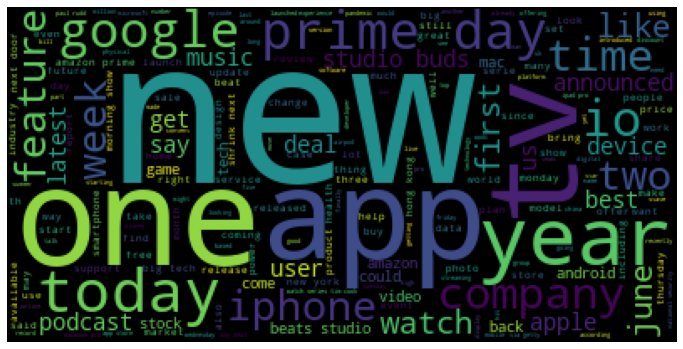

In [ ]:
# Plot wordcount

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

### Functionizing Word Clouds

In [ ]:
# Add company names to stopword list

stopwords_list.append('Apple')
stopwords_list.append('Facebook')
stopwords_list.append('Microsoft')
stopwords_list.append('Google')
stopwords_list.append('Netflix')
stopwords_list.append('Amazon')

In [ ]:
# Text preprocessor

def preprocess_text(sentence):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer = RegexpTokenizer(pattern)
    tokens = tokenizer.tokenize(sentence)
    stopped_tokens= [w.lower() for w in tokens  if w.lower() not in stopwords_list]
    return stopped_tokens

In [ ]:
#Functionize wordcloud maker

def create_wordcloud(df, sent, stop):

  wordcloud = WordCloud(collocations=True, stopwords=stop)
  df['tokens'] = df['cont_joined'].map(lambda x: preprocess_text(x))
  corpus = df[df['Sentiment']==sent]['cont_joined'].to_list()
  corpus = ",".join(corpus)
  wordcloud.generate(corpus)
  plt.figure(figsize = (12, 12), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis('off')

In [ ]:
create_wordcloud(df_apple,-1,stopwords_list)

NameError: ignored

## TF-IDF Vectorizer

In [ ]:
# Create X and y data

X = apple.iloc[:,8]
y= apple.iloc[:,-2]

In [ ]:
# Perform train-test-split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                    random_state=42)

In [ ]:
# Check distribution
# Add visual here

y_train.value_counts(normalize=True)

 1    0.525434
 0    0.317175
-1    0.157391
Name: Sentiment, dtype: float64

In [ ]:
# Ensure shapes line up properly

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1671,)
(717,)
(1671,)
(717,)


In [ ]:
# Create vectorizer object

from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = RegexpTokenizer(pattern)

vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_list)

In [ ]:
# Fit transform train test, transform test data

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amazon', 'facebook', 'google', 'microsoft', 'netflix'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
# Ensure shapes match

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(1671, 10162)
(717, 10162)


In [ ]:
# Bring in random forest

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced')

In [ ]:
# Fit model

rf.fit(X_train_tfidf,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

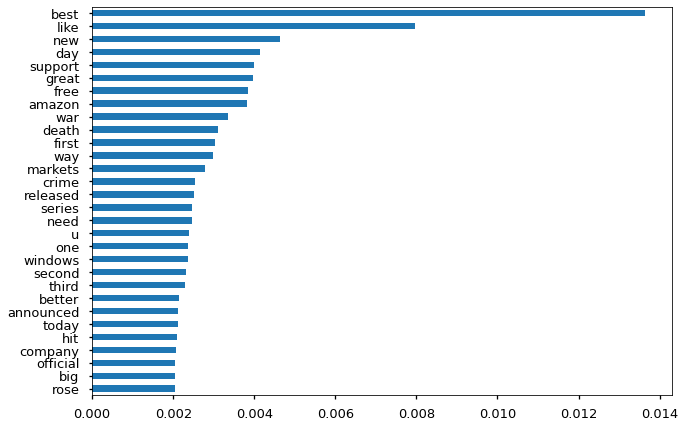

In [ ]:
# Check feature importances
# Do this with pipeline

import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

with plt.style.context('seaborn-talk'):

    ## Get Feature Importance
    importance = pd.Series(rf.feature_importances_,
                           index=vectorizer.get_feature_names())

    ## Take the .tail 30 and plot kind='barh'
    importance.sort_values().tail(30).plot(kind='barh')

## Random Forest Model

In [ ]:
# Dummy Classifier
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train_tfidf,y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(fit_model, X_train, X_test, y_train, y_test, cmap='Blues', normalize='true'):
    """
    Returns results of a fit model
    Parameters: fit model, training and test data, can optionally adjust color palette and normalized matrix
    Returns: Classification report, ROC curve, AUC score, confusion matrix, and training vs test F1 results
    """
    
    y_hat_test = fit_model.predict(X_test)
    y_hat_train = fit_model.predict(X_train)
    print('********************CLASSIFICATION REPORT - TRAIN *************************') 
    print(classification_report(y_train, y_hat_train))
    print('********************CLASSIFICATION REPORT - TEST *************************') 
    print(classification_report(y_test, y_hat_test))
    print('*********************************************************************') 
    
    # fig, axes = plt.subplots(ncols=2, figsize=(10,4))
    # plot_roc_curve(fit_model, X_test, y_test, ax=axes[0])
    cm = cm = confusion_matrix(y_test, y_hat_test)
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    


********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.17      0.16      0.16       263
           0       0.34      0.35      0.34       530
           1       0.54      0.55      0.54       878

    accuracy                           0.42      1671
   macro avg       0.35      0.35      0.35      1671
weighted avg       0.42      0.42      0.42      1671

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.18      0.20      0.19        99
           0       0.36      0.35      0.36       235
           1       0.56      0.55      0.55       383

    accuracy                           0.44       717
   macro avg       0.37      0.37      0.37       717
weighted avg       0.44      0.44      0.44       717

*********************************************************************


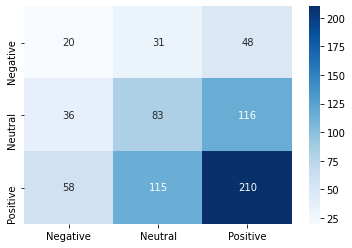

In [ ]:
evaluate_model(dummy_clf, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# accuracy_score()
y_pred = rf.predict(X_test_tfidf)


In [ ]:
depths = [rf.estimators_[i].get_depth() for i in range(100)]

In [ ]:
from statistics import mean
np.array(depths).mean()

229.89

In [ ]:
accuracy_score(y_test, y_pred)

0.6401673640167364

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       263
           0       1.00      1.00      1.00       530
           1       1.00      1.00      1.00       878

    accuracy                           1.00      1671
   macro avg       1.00      1.00      1.00      1671
weighted avg       1.00      1.00      1.00      1671

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.72      0.26      0.39        99
           0       0.55      0.48      0.51       235
           1       0.67      0.84      0.75       383

    accuracy                           0.64       717
   macro avg       0.65      0.53      0.55       717
weighted avg       0.64      0.64      0.62       717

*********************************************************************


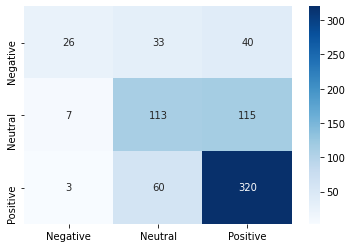

In [ ]:
evaluate_model(rf, X_train_tfidf, X_test_tfidf, y_train, y_test)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
clf_lr = LogisticRegression(C=1e12, class_weight='balanced')

In [ ]:
clf_lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       263
           0       1.00      1.00      1.00       530
           1       1.00      1.00      1.00       878

    accuracy                           1.00      1671
   macro avg       1.00      1.00      1.00      1671
weighted avg       1.00      1.00      1.00      1671

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.48      0.36      0.41        99
           0       0.52      0.49      0.50       235
           1       0.69      0.77      0.73       383

    accuracy                           0.62       717
   macro avg       0.57      0.54      0.55       717
weighted avg       0.61      0.62      0.61       717

*********************************************************************


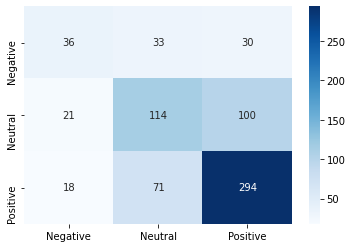

In [ ]:
evaluate_model(clf_lr, X_train_tfidf, X_test_tfidf, y_train, y_test)

## Building Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
text_pipe = Pipeline(steps=[
    ('count_vectorizer',CountVectorizer(lowercase=True)),
    ('tf_transformer',TfidfTransformer(use_idf=True))
])

In [ ]:
# Doesn't need to be a pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
# text_pipe = TfidfVectorizer(tokenizer.tokenize, lowercase=True)

In [ ]:
full_pipe = Pipeline([('text_pipe',text_pipe),
                     ('clf',RandomForestClassifier(class_weight='balanced', n_jobs=-1))])

In [ ]:
full_pipe.get_params()

{'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                        warm_start=False),
 'clf__bootstrap': True,
 'clf__ccp_alpha': 0.0,
 'clf__class_weight': 'balanced',
 'clf__criterion': 'gini',
 'clf__max_depth': None,
 'clf__max_features': 'auto',
 'clf__max_leaf_nodes': None,
 'clf__max_samples': None,
 'clf__min_impurity_decrease': 0.0,
 'clf__min_impurity_split': None,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__n_estimators': 100,
 'clf__n_jobs': 

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'text_pipe__use_idf':[True],
         'text_pipe__smooth_idf':[True,False],
        #  'text_pipe__stop_words':[stopwords_list, 'english'],
        #  'text_pipe__ngram_range': [(1, 2), (1,1)], #make change to ngram
        # 'text_pipe__max_df':[1.0,0.99],
        # 'text_pipe__min_df':[0.01, 0.03],
        'text_pipe__norm':['l2','l1'],
        'clf__criterion':['gini','entropy'],
        # 'clf__max_depth':[None, 100, 200],
        # 'clf__min_samples_leaf': [1,5]
         }

## Make and fit grid
# grid4 = GridSearchCV(full_pipe,
#                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
# grid4.fit(X_train,y_train)
# ## Display best params
# grid4.best_params_

In [ ]:
# test =grid4.best_estimator_.named_steps['text_pipe']

In [ ]:
## Get Feature Importance
# importance = pd.Series(fi2,
#                         index=tp2.get_feature_names())

# ## Take the .tail 30 and plot kind='barh'
# importance.sort_values().tail(30).plot(kind='barh')

In [ ]:
# fi = grid4.best_estimator_
# fi.named_steps['clf'].feature_importances_

In [ ]:
# test = grid3.best_params_
# test.

In [ ]:
# fi2 =grid4.best_estimator_.named_steps['clf'].feature_importances_

In [ ]:
# fi = grid4.best_estimator_
# tp2 = fi.named_steps['text_pipe']

In [ ]:
# # apply grid search results
# def create_vars(X_train, y_train, grid):
  
#   # Establish variables
#   clf = grid.best_estimator_.named_steps['clf']
#   vectorizer = grid.best_estimator_.named_steps['text_pipe']
#   X_train_tfidf = vectorizer.fit_transform(X_train)
#   X_test_tfidf = vectorizer.transform(X_test)

#   return clf, X_train_tfidf, X_test_tfidf

In [ ]:
# clf_t, X_train_tfidf_t, X_test_tfidf_t = create_vars(X_train, y_train, grid4)

In [ ]:
# evaluate_model(clf_t, X_train_tfidf_t, X_test_tfidf_t, y_train, y_test)

In [ ]:
# evaluate_model(grid3.best_estimator_.named_steps['clf'], X_train_tfidf, X_test_tfidf, y_train, y_test)

In [ ]:
# Takes 15 mins to run
# Use english
# maybe test another scoring metric (recall macro)
# change max depth

# from sklearn.model_selection import GridSearchCV
params = {'text_pipe__TfidfVectorizer__use_idf':[True,False],
        'text_pipe__TfidfVectorizer__norm':['l2','l1'],
         'text_pipe__TfidfVectorizer__smooth_idf':[True,False],
         'text_pipe__TfidfVectorizer__stop_words':[stopwords_list,'english'],
          'text_pipe__TfidfVectorizer__ngram_range': [(1, 2)], #make change to ngram
          'text_pipe__TfidfVectorizer__max_df':[1.0,0.99],
          'text_pipe__TfidfVectorizer__min_df':[0.01, 0.03],
          'clf__criterion':['gini','entropy'],
          'clf__max_depth':[None, 5],
          'clf__min_samples_leaf': [1,5]
         }

# ## Make and fit grid
# grid2 = GridSearchCV(full_pipe,
#                    params, cv=3, scoring='recall_macro',n_jobs=-1,verbose=2)
# grid2.fit(X_train,y_train)
# ## Display best params
# grid2.best_params_

In [ ]:
# Move model into model folder

import joblib
# joblib.dump(grid2, '/content/drive/MyDrive/Colab Notebooks/Data/apple1_nlp.pkl')

In [ ]:
# url = 'https://github.com/kuninethan95/Sentiment_Tracker/blob/main/grid_estimator_models/am1_bp.pkl'
# url2 = 'https://drive.google.com/file/d/1omsOGmAfQfxNAooSumC-lymLzNilR58l/view?usp=sharing'
# apple_pipe = joblib.load(url2)
# apple_pipe = joblib.load('/content/drive/MyDrive/Colab Notebooks/Data/models/apple1_nlp.pkl')

FileNotFoundError: ignored

In [ ]:
# apple_pipe = joblib.load('/content/drive/MyDrive/Colab Notebooks/Data/models/apple1_nlp.pkl')

In [ ]:
# Save this using joblib
# Don't save grid because it contains excess data

apple1_best_est= apple_pipe.best_estimator_
apple1_best_est

In [ ]:
apple_pipe

NameError: ignored

In [ ]:
apple1_best_est.named_steps['clf']

NameError: ignored

In [ ]:
apple1_best_est.named_steps['clf'].feature_importances_

NameError: ignored

In [ ]:
# Why can't I add max,min df?
# update sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

pipe_vect2 = TfidfVectorizer(norm='l1', smooth_idf=False, stop_words=stopwords_list, use_idf=True,max_df=1, min_df=0.01)

In [ ]:
X_train_tfidf = pipe_vect2.fit_transform(X_train)
X_test_tfidf = pipe_vect2.transform(X_test)

ValueError: ignored

In [ ]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(1671, 10162)
(717, 10162)


In [ ]:
pipe_rf2 = RandomForestClassifier(class_weight='balanced', max_depth=None, min_samples_leaf=1)
pipe_rf2.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       263
           0       1.00      1.00      1.00       530
           1       1.00      1.00      1.00       878

    accuracy                           1.00      1671
   macro avg       1.00      1.00      1.00      1671
weighted avg       1.00      1.00      1.00      1671

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.69      0.22      0.34        99
           0       0.56      0.44      0.49       235
           1       0.66      0.86      0.75       383

    accuracy                           0.64       717
   macro avg       0.64      0.51      0.53       717
weighted avg       0.63      0.64      0.61       717

*********************************************************************


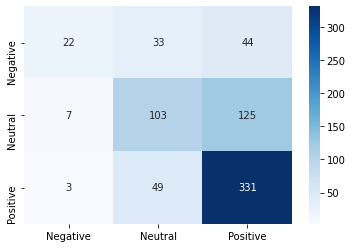

In [ ]:
evaluate_model(pipe_rf2, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [ ]:
pipe_rf2.feature_importances_

array([4.38116934e-04, 6.37429702e-06, 5.32716097e-05, ...,
       1.03823966e-04, 6.27453472e-05, 0.00000000e+00])

In [ ]:
pipe_vect2.get_feature_names()[220:230]

NotFittedError: ignored

In [ ]:
# Maybe remove numbers

In [ ]:
X_test_tfidf

<717x10162 sparse matrix of type '<class 'numpy.float64'>'
	with 14473 stored elements in Compressed Sparse Row format>

In [ ]:
## Get Feature Importance
importance = pd.Series(pipe_rf2.feature_importances_,
                        index=pipe_vect2.get_feature_names())

## Take the .tail 30 and plot kind='barh'
importance.sort_values().tail(30).plot(kind='barh')

NotFittedError: ignored

# Interpretation

## RFM Feature Interpetation

In [ ]:
best_params = grid4.best_estimator_

In [ ]:
best_params.named_steps['clf']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
def create_vars(grid,X_train, y_train):
  
  # Establish variables
  clf = grid.named_steps['clf']
  vecto = grid.named_steps['text_pipe']
  X_train_tfidf = vecto.fit_transform(X_train)
  X_test_tfidf = vecto.transform(X_test)

  return clf, vecto, X_train_tfidf, X_test_tfidf

In [ ]:
clf5, vect5, X_train_tfidf5, X_test_tfidf5 = create_vars(best_params,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       263
           0       1.00      1.00      1.00       530
           1       1.00      1.00      1.00       878

    accuracy                           1.00      1671
   macro avg       1.00      1.00      1.00      1671
weighted avg       1.00      1.00      1.00      1671

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.76      0.16      0.27        99
           0       0.55      0.26      0.35       235
           1       0.59      0.91      0.72       383

    accuracy                           0.59       717
   macro avg       0.63      0.44      0.44       717
weighted avg       0.60      0.59      0.53       717

*********************************************************************


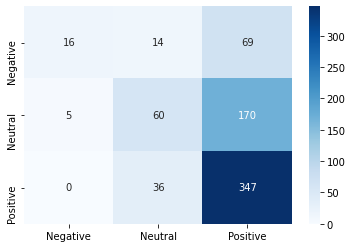

In [ ]:
evaluate_model(clf5, X_train_tfidf5, X_test_tfidf5, y_train, y_test)

In [ ]:
def create_feature_importance(clf, vect, company):
  importance = pd.Series(clf.feature_importances_,
                        index=vect.get_feature_names())
  if company in importance:
    importance.drop(company, inplace=True)
  else:
    pass
  

  # Take the .tail 30 and plot kind='barh'
  ax = importance.sort_values().tail(25).plot(kind='barh')
  return ax

In [ ]:
importance.drop('aapl', inp)

NameError: ignored

In [ ]:
fig = create_feature_importance(clf5, vect5)

NameError: ignored

In [ ]:
grid4.best_estimator_.named_steps['clf']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
test = grid4.best_estimator_

In [ ]:
test.named_steps['clf']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
importance = pd.Series(clf.feature_importances_,
                      index=vect.get_feature_names())

# Take the .tail 30 and plot kind='barh'
# vibes = importance.sort_values().tail(25).plot(kind='barh')
ax.barh(width=importance.sort_values(), y=vect.get_feature_names())

<BarContainer object of 10490 artists>

In [ ]:
test=importance.sort_values(ascending=False).to_frame()

In [ ]:
test = test.nlargest(30, columns=0)
test=test.sort_values(by=0)
test

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

fig = px.bar(test, y=test.index, x=0, orientation='h')
layout1 = go.Layout(
title="Feature Importance",
xaxis=dict(
           tickvals=test.index,
    title='Feature Importance',
    titlefont=dict(
        family='Courier New, monospace',
        size=18,
        color='#7f7f7f'
    )))
fig.show()

In [ ]:
importance.sort_values().nlargest(30)

best     0.008477
the      0.007505
and      0.007447
for      0.007017
to       0.006833
in       0.006770
of       0.006381
you      0.006091
apple    0.005492
on       0.005458
is       0.005286
with     0.004868
new      0.004723
it       0.004501
has      0.004433
an       0.004033
this     0.003729
at       0.003689
that     0.003649
like     0.003540
from     0.003476
day      0.003461
as       0.003450
be       0.003376
are      0.003295
was      0.003231
its      0.003188
by       0.002996
war      0.002899
first    0.002829
dtype: float64

# Prep Data for Feature importance


## APPLE DATA

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

full_pipe = Pipeline([('text_pipe',text_pipe),
                     ('clf',RandomForestClassifier(class_weight='balanced', n_jobs=-1))])

In [ ]:
# Make note at top of NB or what run_grid does
# Set to False as default
run_grid=False
import joblib, os
DATA_MODEL= f'{DATA_PATH}/models/'
os.makedirs(DATA_MODEL, exist_ok=True)



if run_grid:

  params = {
          'text_pipe__use_idf':[True],
          'text_pipe__stop_words':[stopwords_list, 'english'],
          'text_pipe__ngram_range': [(1, 2), (1,1)], #make change to ngram
          'text_pipe__max_df':[1.0,0.99],
          'text_pipe__min_df':[0.01, 0.03],
          'text_pipe__norm':['l2','l1'],
          'clf__criterion':['gini','entropy'],
          'clf__max_depth':[None, 100, 200],
          'clf__min_samples_leaf': [1,5]
          }

  # Make and fit grid
  apple1 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  apple1.fit(X_train,y_train)

  # Save best estimator
  apple1_bp = apple1.best_estimator_
  
  joblib.dump(apple1_bp, f'{DATA_MODEL}apple1_bp.pkl')
else:
  apple1_bp=joblib.load(f'{DATA_MODEL}apple1_bp.pkl')
  print('Sucessfully loaded pickle file')
apple1_bp



Link to download Apple 1 Model: https://drive.google.com/file/d/1omsOGmAfQfxNAooSumC-lymLzNilR58l/view?usp=sharing

['/content/drive/MyDrive/Colab Notebooks/Data/apple1_bp.pkl']

In [ ]:
apple1_clf, apple1_vect, X_train_apple1, X_test_apple1 = create_vars(app,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99       263
           0       1.00      1.00      1.00       530
           1       1.00      1.00      1.00       878

    accuracy                           1.00      1671
   macro avg       0.99      1.00      1.00      1671
weighted avg       1.00      1.00      1.00      1671

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.33      0.26      0.29        99
           0       0.52      0.45      0.48       235
           1       0.68      0.77      0.72       383

    accuracy                           0.60       717
   macro avg       0.51      0.49      0.50       717
weighted avg       0.58      0.60      0.58       717

*********************************************************************


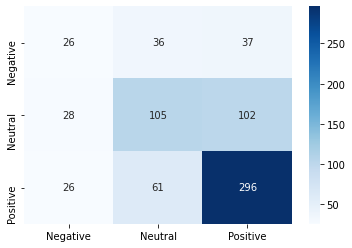

In [ ]:
evaluate_model(apple1_clf, X_train_apple1, X_test_apple1, y_train, y_test)

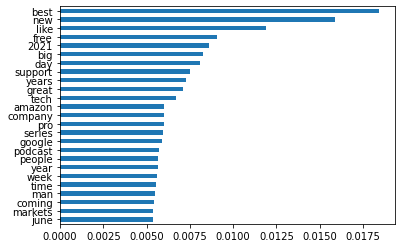

In [ ]:
apple1_fi = create_feature_importance(apple1_clf, apple1_vect, 'apple')

Apple Week 2

In [ ]:
app2 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_apple2.csv'
apple2 = pd.read_csv(app2)

In [ ]:
apple2.head(3)

,publishedAt,title,description,content,results,source2,hour,day,cont_joined,neg,neu,pos,comp,blob,comp_abs,blob_abs,c_b,Sentiment
0,2021-06-21 09:00:01-04:00,watchOS 8: Everything you want to know about t...,Table of contents<ol><li>watchOS 8: A summary<...,Table of contents<ol><li>watchOS 8: A summary<...,130.0,Nextpit,9.0,21.0,watchOS 8: Everything you want to know about t...,0.0,0.963,0.037,0.0772,0.136364,0,0,-0.059164,0
1,2021-06-21 09:00:25-04:00,Used Apple iPhone 8 Plus 64GB GSM Smartphone f...,Connecting you to your offer...If you don't ar...,Connecting you to your offer...If you don't ar...,130.0,TechRepublic,9.0,21.0,Used Apple iPhone 8 Plus 64GB GSM Smartphone f...,0.0,0.804,0.196,0.6808,0.100000,1,0,0.580800,1
2,2021-06-21 09:00:26-04:00,WhatsApp for iOS now lets users forward offici...,WhatsApp is releasing a new feature exclusivel...,WhatsApp is releasing a new feature exclusivel...,130.0,9to5Mac,9.0,21.0,WhatsApp for iOS now lets users forward offici...,0.0,1.000,0.000,0.0000,0.221591,0,1,-0.221591,0


In [ ]:
X = apple2.iloc[:,8]
y = apple2.iloc[:,-1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                    random_state=42)

In [ ]:
## Produce gridsearch best estimator

if run_grid:
  # Run grid search and fit model
  apple2 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  apple2.fit(X_train,y_train)

  # Save best_estimator

  apple2_bp = apple2.best_estimator_
  joblib.dump(apple2_bp, '/content/drive/MyDrive/Colab Notebooks/Data/apple2_bp.pkl')

else:
  apple2_bp=joblib.load(f'{DATA_MODEL}apple2_bp.pkl')
  print('Sucessfully loaded pickle file')
apple1_bp

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 10.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOT...
                         'text_pipe__stop_words': [['i', 'me', 'my', 'myself',
                                                    'we', 'our', 'ours',
                                                    'ourselves', 'you',
                                        

In [ ]:
apple2_clf, apple2_vect, X_train_apple2, X_test_apple2 = create_vars(apple2_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       242
           0       1.00      1.00      1.00       538
           1       1.00      1.00      1.00      1015

    accuracy                           1.00      1795
   macro avg       1.00      1.00      1.00      1795
weighted avg       1.00      1.00      1.00      1795

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.44      0.22      0.30        89
           0       0.49      0.40      0.44       232
           1       0.68      0.82      0.75       449

    accuracy                           0.62       770
   macro avg       0.54      0.48      0.50       770
weighted avg       0.60      0.62      0.60       770

*********************************************************************


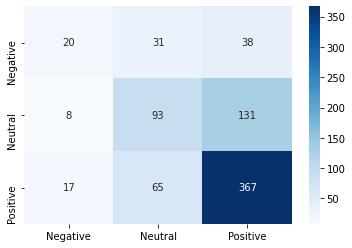

In [ ]:
evaluate_model(apple2_clf, X_train_apple2, X_test_apple2, y_train, y_test)

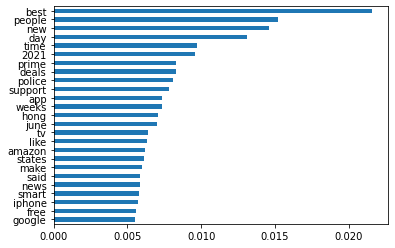

In [ ]:
apple2_fi = create_feature_importance(apple2_clf, apple2_vect, 'apple')

## FACEBOOK DATA

In [ ]:
# Load in FB Data from crisp folder
fb1 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_fb1.csv'
X_train, X_test, y_train, y_test = train_test(fb1)

In [ ]:
## Produce gridsearch best estimator

if run_grid:

  # Run grid search and fit model
  fb1 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  fb1.fit(X_train,y_train)

  # Save best_estimator
  fb1_bp = fb1.best_estimator_
  joblib.dump(fb1_bp, '/content/drive/MyDrive/Colab Notebooks/Data/fb1_bp.pkl')
else:
  fb1_bp=joblib.load(f'{DATA_MODEL}fb1_bp.pkl')
  print('Sucessfully loaded pickle file')
fb1_bp

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  9.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOT...
                         'text_pipe__stop_words': [['i', 'me', 'my', 'myself',
                                                    'we', 'our', 'ours',
                                                    'ourselves', 'you',
                                        

In [ ]:
fb1_clf, fb1_vect, X_train_fb1, X_test_fb1 = create_vars(fb1_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       435
           0       1.00      1.00      1.00       577
           1       1.00      1.00      1.00       745

    accuracy                           1.00      1757
   macro avg       1.00      1.00      1.00      1757
weighted avg       1.00      1.00      1.00      1757

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.52      0.53      0.53       196
           0       0.50      0.46      0.48       224
           1       0.65      0.68      0.66       333

    accuracy                           0.58       753
   macro avg       0.56      0.56      0.56       753
weighted avg       0.57      0.58      0.57       753

*********************************************************************


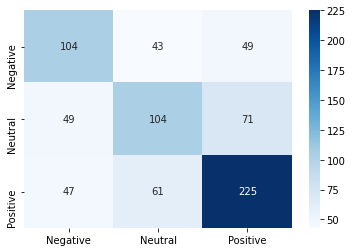

In [ ]:
evaluate_model(fb1_clf, X_train_fb1, X_test_fb1, y_train, y_test)

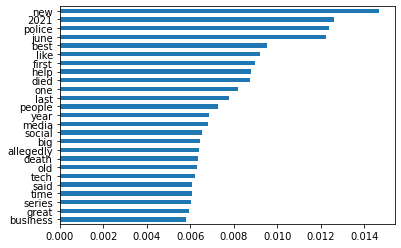

In [ ]:
fb1_fi = create_feature_importance(fb1_clf, fb1_vect, 'facebook')

Facebook Week 2 Data

In [ ]:
fb2= 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_fb2.csv'
X_train, X_test, y_train, y_test = train_test(fb2)

In [ ]:
## Produce gridsearch best estimator

if run_grid:

  # Run grid search and fit model
  fb2 = GridSearchCV(full_pipe,
                    params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
  fb2.fit(X_train,y_train)

  # Save best estimator
  fb2_bp = fb2.best_estimator_
  joblib.dump(fb2_bp, '/content/drive/MyDrive/Colab Notebooks/Data/fb2_bp.pkl')

else:
  fb2_bp=joblib.load(f'{DATA_MODEL}fb2_bp.pkl')
  print('Sucessfully loaded pickle file')
fb2_bp 

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  9.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOT...
                         'text_pipe__stop_words': [['i', 'me', 'my', 'myself',
                                                    'we', 'our', 'ours',
                                                    'ourselves', 'you',
                                        

In [ ]:
fb2_clf, fb2_vect, X_train_fb2, X_test_fb2 = create_vars(fb2_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       418
           0       1.00      1.00      1.00       509
           1       1.00      1.00      1.00       840

    accuracy                           1.00      1767
   macro avg       1.00      1.00      1.00      1767
weighted avg       1.00      1.00      1.00      1767

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.68      0.47      0.56       195
           0       0.49      0.34      0.40       229
           1       0.57      0.79      0.66       334

    accuracy                           0.57       758
   macro avg       0.58      0.53      0.54       758
weighted avg       0.57      0.57      0.56       758

*********************************************************************


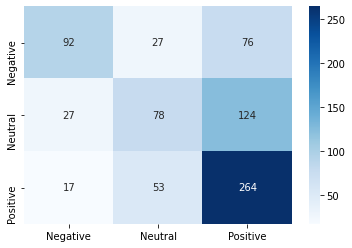

In [ ]:
evaluate_model(fb2_clf, X_train_fb2, X_test_fb2, y_train, y_test)

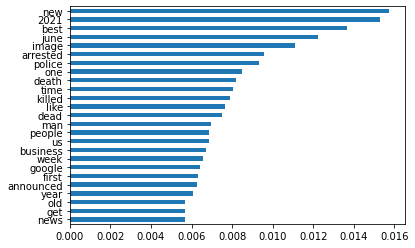

In [ ]:
fb2_fi = create_feature_importance(fb2_clf, fb2_vect, 'facebook')

## NETFLIX DATA

In [ ]:
def train_test(filepath):

  # Load in FB Data from crisp folder
  df = pd.read_csv(filepath)

  # Create X and y data
  X = df.iloc[:,8]
  y= df.iloc[:,-1]

  # Train-test split
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                      random_state=42)
  return X_train, X_test, y_train, y_test

In [ ]:
nflx1 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_nflx1.csv'
X_train, X_test, y_train, y_test = train_test(nflx1)

In [ ]:
nf1 = GridSearchCV(full_pipe,
                   params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
# nf1.fit(X_train,y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOT...
                         'text_pipe__stop_words': [['i', 'me', 'my', 'myself',
                                                    'we', 'our', 'ours',
                                                    'ourselves', 'you',
                                        

In [ ]:
nf1_bp = nf1.best_estimator_
# joblib.dump(nf1_bp, '/content/drive/MyDrive/Colab Notebooks/Data/nf1_bp.pkl')

['/content/drive/MyDrive/Colab Notebooks/Data/fb1_bp.pkl']

Link to download Netflix *1* Model: https://drive.google.com/file/d/1-0sXyLb_STQW-djaHpLLAMmsGkzKnwE-/view?usp=sharing

In [ ]:
nf1_clf, nf1_vect, X_train_nf1, X_test_nf1 = create_vars(nf1_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.99      1.00      1.00       140
           0       1.00      0.99      1.00       194
           1       1.00      1.00      1.00       389

    accuracy                           1.00       723
   macro avg       1.00      1.00      1.00       723
weighted avg       1.00      1.00      1.00       723

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.58      0.25      0.35        57
           0       0.54      0.37      0.44        92
           1       0.62      0.85      0.72       162

    accuracy                           0.60       311
   macro avg       0.58      0.49      0.50       311
weighted avg       0.59      0.60      0.57       311

*********************************************************************


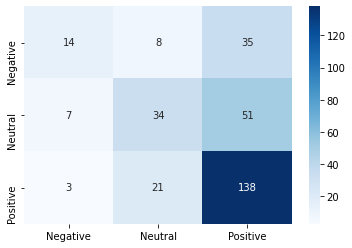

In [ ]:
evaluate_model(nf1_clf, X_train_nf1, X_test_nf1, y_train, y_test)

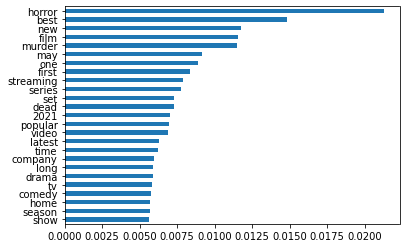

In [ ]:
nf1_fi = create_feature_importance(nf1_clf, nf1_vect, 'netflix')

In [ ]:
nflx2 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_nflx2.csv'
X_train, X_test, y_train, y_test = train_test(nflx2)

In [ ]:
from sklearn.model_selection import GridSearchCV
nf2 = GridSearchCV(full_pipe,
                   params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
# nf2.fit(X_train,y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  6.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOT...
                         'text_pipe__stop_words': [['i', 'me', 'my', 'myself',
                                                    'we', 'our', 'ours',
                                                    'ourselves', 'you',
                                        

Link to download Netflix 2 Model: https://drive.google.com/file/d/1-PodbDrGYhHvnakEevU1IE-4X6ixCXv3/view?usp=sharing

In [ ]:
import joblib
nf2_bp = nf2.best_estimator_
# joblib.dump(nf2_bp, '/content/drive/MyDrive/Colab Notebooks/Data/nf2_bp.pkl')

['/content/drive/MyDrive/Colab Notebooks/Data/nf2_bp.pkl']

In [ ]:
nf2_clf, nf2_vect, X_train_nf2, X_test_nf2 = create_vars(nf2_bp,X_train, y_train)

In [ ]:
evaluate_model(nf2_clf, X_train_nf2, X_test_nf2, y_train, y_test)

In [ ]:
nf1_f2 = create_feature_importance(nf2_clf, nf2_vect, 'netflix')

## AMAZON DATA

In [ ]:
am1 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_am1.csv'
X_train, X_test, y_train, y_test = train_test(am1)

In [ ]:
from sklearn.model_selection import GridSearchCV

am1 = GridSearchCV(full_pipe,
                   params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
# am1.fit(X_train,y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 10.6min finished
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amazon', 'facebook', 'google', 'microsoft', 'netflix'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOT...
                         'text_pipe__stop_words': [['i', 'me', 'my', 'myself',
                                                    'we', 'our', 'ours',
                                                    'ourselves', 'you',
                                        

Link to Amazon 1 Model: https://drive.google.com/file/d/1mxAsWKPnjmTpo-UWmzlQ-3-xbf8zWJFM/view?usp=sharing

In [ ]:
import joblib
am1_bp = am1.best_estimator_
# joblib.dump(am1_bp, '/content/drive/MyDrive/Colab Notebooks/Data/am1_bp.pkl')

['/content/drive/MyDrive/Colab Notebooks/Data/am1_bp.pkl']

In [ ]:
am1_clf, am1_vect, X_train_am1, X_test_am1 = create_vars(am1_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.97      1.00      0.98       202
           0       1.00      0.99      0.99       473
           1       1.00      1.00      1.00      1045

    accuracy                           1.00      1720
   macro avg       0.99      1.00      0.99      1720
weighted avg       1.00      1.00      1.00      1720

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.34      0.11      0.17        88
           0       0.46      0.34      0.39       187
           1       0.71      0.87      0.78       463

    accuracy                           0.65       738
   macro avg       0.51      0.44      0.45       738
weighted avg       0.60      0.65      0.61       738

*********************************************************************


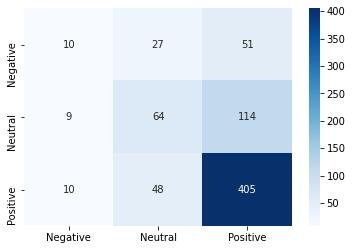

In [ ]:
evaluate_model(am1_clf, X_train_am1, X_test_am1, y_train, y_test)

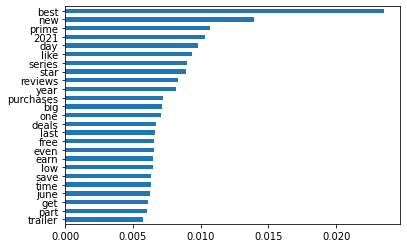

In [ ]:
am1_fi = create_feature_importance(am1_clf, am1_vect, 'amazon')

In [ ]:
am2 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_am2.csv'
X_train, X_test, y_train, y_test = train_test(am2)

In [ ]:
am2 = GridSearchCV(full_pipe,
                   params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
# am2.fit(X_train,y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 10.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOT...
                         'text_pipe__stop_words': [['i', 'me', 'my', 'myself',
                                                    'we', 'our', 'ours',
                                                    'ourselves', 'you',
                                        

Link to Amazon 2 Model: https://drive.google.com/file/d/1-Ab1QtMY0I1Gdv4chofBU1tou8ac6kYL/view?usp=sharing

In [ ]:
am2_bp = am2.best_estimator_
joblib.dump(am2_bp, '/content/drive/MyDrive/Colab Notebooks/Data/am2_bp.pkl')

['/content/drive/MyDrive/Colab Notebooks/Data/am2_bp.pkl']

In [ ]:
am2_clf, am2_vect, X_train_am2, X_test_am2 = create_vars(am2_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       1.00      0.99      0.99       181
           0       0.99      1.00      0.99       426
           1       1.00      1.00      1.00      1216

    accuracy                           1.00      1823
   macro avg       1.00      1.00      1.00      1823
weighted avg       1.00      1.00      1.00      1823

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.45      0.21      0.28        68
           0       0.49      0.32      0.39       207
           1       0.73      0.89      0.80       507

    accuracy                           0.68       782
   macro avg       0.56      0.47      0.49       782
weighted avg       0.64      0.68      0.65       782

*********************************************************************


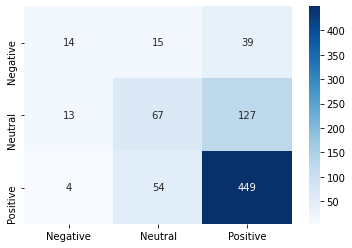

In [ ]:
evaluate_model(am2_clf, X_train_am2, X_test_am2, y_train, y_test)

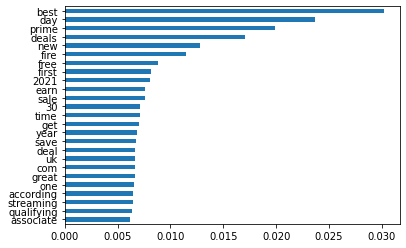

In [ ]:
am2_fi = create_feature_importance(am2_clf, am2_vect, 'amazon')

## GOOGLE DATA

In [ ]:
goog1 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_goog1.csv'
X_train, X_test, y_train, y_test = train_test(goog1)

In [ ]:
goog1 = GridSearchCV(full_pipe,
                   params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
# goog1.fit(X_train,y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 11.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOT...
                         'text_pipe__stop_words': [['i', 'me', 'my', 'myself',
                                                    'we', 'our', 'ours',
                                                    'ourselves', 'you',
                                        

In [ ]:
goog1_bp = goog1.best_estimator_
# joblib.dump(goog1_bp, '/content/drive/MyDrive/Colab Notebooks/Data/goog1_bp.pkl')

['/content/drive/MyDrive/Colab Notebooks/Data/goog1_bp.pkl']

Link to Google 1 Model: https://drive.google.com/file/d/1WgvavG93tAagMgNCvKgvIKECJmmtyotI/view?usp=sharing

In [ ]:
goog1_clf, goog1_vect, X_train_goog1, X_test_goog1 = create_vars(goog1_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.99      0.99      0.99       377
           0       0.99      1.00      1.00       725
           1       1.00      1.00      1.00       897

    accuracy                           1.00      1999
   macro avg       0.99      0.99      0.99      1999
weighted avg       1.00      1.00      1.00      1999

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.56      0.34      0.42       158
           0       0.51      0.60      0.55       281
           1       0.67      0.69      0.68       419

    accuracy                           0.59       858
   macro avg       0.58      0.54      0.55       858
weighted avg       0.60      0.59      0.59       858

*********************************************************************


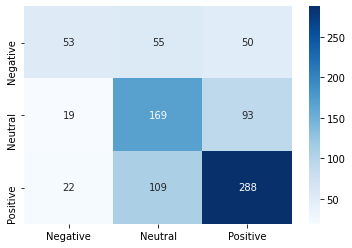

In [ ]:
evaluate_model(goog1_clf, X_train_goog1, X_test_goog1, y_train, y_test)

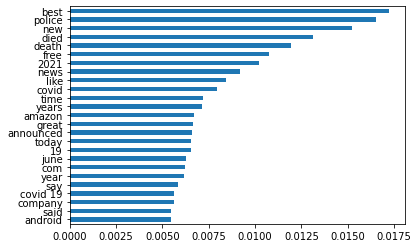

In [ ]:
goog1_fi = create_feature_importance(goog1_clf, goog1_vect, 'google')

In [ ]:
goog2 = 'https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_goog2.csv'
X_train, X_test, y_train, y_test = train_test("/content/drive/MyDrive/Colab Notebooks/Data/crisp_data/df_etl_goog2.csv")

In [ ]:
goog2 = GridSearchCV(full_pipe,
                   params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
# goog2.fit(X_train,y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 11.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOT...
                         'text_pipe__stop_words': [['i', 'me', 'my', 'myself',
                                                    'we', 'our', 'ours',
                                                    'ourselves', 'you',
                                        

In [ ]:
goog2_bp = goog2.best_estimator_
# joblib.dump(goog2_bp, '/content/drive/MyDrive/Colab Notebooks/Data/goog2_bp.pkl')

['/content/drive/MyDrive/Colab Notebooks/Data/goog2_bp.pkl']

Link to Google 2 Model: https://drive.google.com/file/d/1-8H_s-G4JXfSy_lLMhfmE9kGMcRn80eF/view?usp=sharing

In [ ]:
goog2_clf, goog2_vect, X_train_goog2, X_test_goog2 = create_vars(goog2_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99       431
           0       1.00      1.00      1.00       664
           1       1.00      1.00      1.00       935

    accuracy                           1.00      2030
   macro avg       1.00      1.00      1.00      2030
weighted avg       1.00      1.00      1.00      2030

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.45      0.50      0.48       149
           0       0.48      0.44      0.46       304
           1       0.66      0.68      0.67       417

    accuracy                           0.57       870
   macro avg       0.53      0.54      0.54       870
weighted avg       0.56      0.57      0.56       870

*********************************************************************


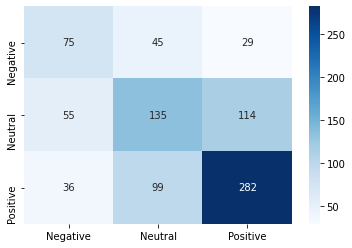

In [ ]:
evaluate_model(goog2_clf, X_train_goog2, X_test_goog2, y_train, y_test)

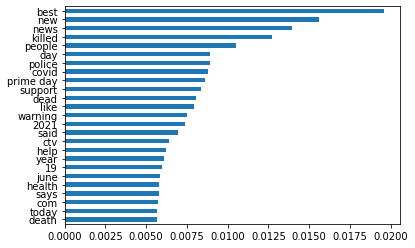

In [ ]:
goog2_fi = create_feature_importance(goog2_clf, goog2_vect, 'google')

## MICROSOFT DATA

In [ ]:
msft1 ='https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_msft1.csv'
X_train, X_test, y_train, y_test = train_test(msft1)

In [ ]:
ms1 = GridSearchCV(full_pipe,
                   params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
# ms1.fit(X_train,y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  7.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOT...
                         'text_pipe__stop_words': [['i', 'me', 'my', 'myself',
                                                    'we', 'our', 'ours',
                                                    'ourselves', 'you',
                                        

In [ ]:
ms1_bp = ms1.best_estimator_
# joblib.dump(ms1_bp, '/content/drive/MyDrive/Colab Notebooks/Data/ms1_bp.pkl')

['/content/drive/MyDrive/Colab Notebooks/Data/ms1_bp.pkl']

Link to Microsoft Model 1: https://drive.google.com/file/d/1-KrodMfOCC2lqiBVrPHM6C8a7rAtv0f5/view?usp=sharing

In [ ]:
ms1_clf, ms1_vect, X_train_ms1, X_test_ms1 = create_vars(ms1_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.99      0.99      0.99       177
           0       1.00      1.00      1.00       403
           1       1.00      1.00      1.00       515

    accuracy                           1.00      1095
   macro avg       1.00      1.00      1.00      1095
weighted avg       1.00      1.00      1.00      1095

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.55      0.35      0.43        65
           0       0.58      0.56      0.57       167
           1       0.69      0.77      0.73       238

    accuracy                           0.64       470
   macro avg       0.61      0.56      0.58       470
weighted avg       0.63      0.64      0.63       470

*********************************************************************


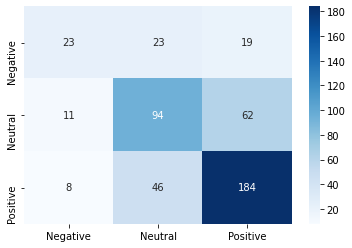

In [ ]:
evaluate_model(ms1_clf, X_train_ms1, X_test_ms1, y_train, y_test)

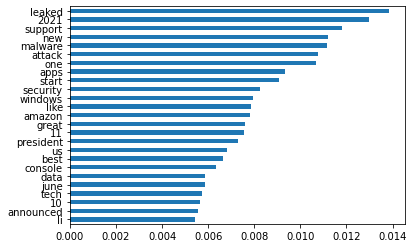

In [ ]:
ms1_fi = create_feature_importance(ms1_clf, ms1_vect, 'microsoft')

In [ ]:
msft2 ='https://raw.githubusercontent.com/kuninethan95/Sentiment_Tracker/main/data/etl_df/df_etl_msft2.csv'
X_train, X_test, y_train, y_test = train_test(msft2)

In [ ]:
ms2 = GridSearchCV(full_pipe,
                   params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
# ms2.fit(X_train,y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  8.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOT...
                         'text_pipe__stop_words': [['i', 'me', 'my', 'myself',
                                                    'we', 'our', 'ours',
                                                    'ourselves', 'you',
                                        

In [ ]:
ms2_bp = ms2.best_estimator_
# joblib.dump(ms2_bp, '/content/drive/MyDrive/Colab Notebooks/Data/ms2_bp.pkl')

['/content/drive/MyDrive/Colab Notebooks/Data/ms2_bp.pkl']

Link to Microsoft 2 Model: https://drive.google.com/file/d/1-LbCj0lgdPygIrRCpmSIRbXHwnUTucuy/view?usp=sharing

In [ ]:
ms2_clf, ms2_vect, X_train_ms2, X_test_ms2 = create_vars(ms2_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99       131
           0       1.00      1.00      1.00       413
           1       1.00      1.00      1.00       706

    accuracy                           1.00      1250
   macro avg       0.99      1.00      0.99      1250
weighted avg       1.00      1.00      1.00      1250

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.67      0.26      0.38        68
           0       0.56      0.55      0.55       177
           1       0.70      0.81      0.75       292

    accuracy                           0.66       537
   macro avg       0.64      0.54      0.56       537
weighted avg       0.65      0.66      0.64       537

*********************************************************************


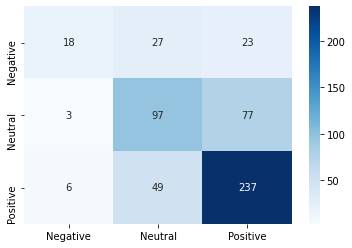

In [ ]:
evaluate_model(ms2_clf, X_train_ms2, X_test_ms2, y_train, y_test)

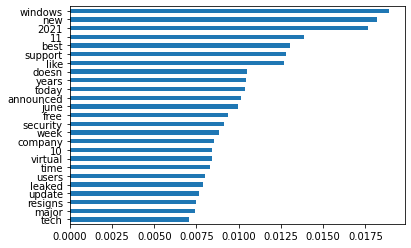

In [ ]:
ms2_fi = create_feature_importance(ms2_clf, ms2_vect, 'microsoft')

# Appendix
- More models

In [ ]:
# Test based on nflx1 data
# shape from fitting and then do the grid search
params2 = {
         'text_pipe__use_idf':[True],
         'text_pipe__stop_words':['english', None],
         'text_pipe__ngram_range': [(1,1)], #make change to ngram
         'text_pipe__max_df':[0.99],
         'text_pipe__min_df':[0.01],

         'text_pipe__norm':['l2','l1'],
         'clf__criterion':['gini','entropy'],
         'clf__max_depth':[None, 100, 200],
         'clf__min_samples_leaf': [1,2,3],
         'clf__min_samples_split': [1,5],
         'clf__max_leaf_nodes': [1,5,20],
     

         }

## Make and fit grid
test_2 = GridSearchCV(full_pipe,
                   params, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
test_2.fit(X_train,y_train)




test_2 = GridSearchCV(full_pipe,
                   params2, cv=3, scoring='accuracy',n_jobs=-1,verbose=2)
test_2.fit(X_train,y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 10.4min finished
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amazon', 'facebook', 'google', 'microsoft', 'netflix'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  4.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('text_pipe',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)", gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOT...
                         'clf__max_leaf_nodes': [1, 5, 20],
                         'clf__min_samples_leaf': [1, 2, 3],
                         'clf__min_samples_split': [1, 5],
                         'text_pipe__max_df': [0.99],
                         'text

In [ ]:
test_bp = test_2.best_estimator_

In [ ]:
test2_clf, test2_vect, X_train_test2, X_test_test2 = create_vars(test_bp,X_train, y_train)

********************CLASSIFICATION REPORT - TRAIN *************************
              precision    recall  f1-score   support

          -1       0.57      0.83      0.67       202
           0       0.49      0.75      0.60       473
           1       0.88      0.60      0.71      1045

    accuracy                           0.67      1720
   macro avg       0.65      0.72      0.66      1720
weighted avg       0.74      0.67      0.67      1720

********************CLASSIFICATION REPORT - TEST *************************
              precision    recall  f1-score   support

          -1       0.25      0.32      0.28        88
           0       0.35      0.60      0.44       187
           1       0.82      0.54      0.65       463

    accuracy                           0.53       738
   macro avg       0.47      0.49      0.46       738
weighted avg       0.63      0.53      0.55       738

*********************************************************************


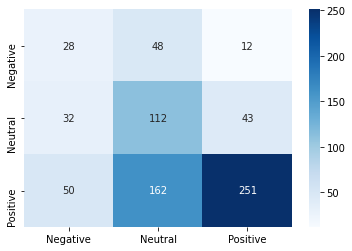

In [ ]:
# Accuracy of 52%, far lower when incorporating for max features
# Accuracy of 53%

evaluate_model(test2_clf, X_train_test2, X_test_test2, y_train, y_test)

## Lime Explainer

In [ ]:
!pip install lime
import lime


     |████████████████████████████████| 276kB 5.4MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283858 sha256=f4a0f6288f8fe484694647f60170efd924b6141d7e4d66a44eefa8bfae87ca89
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


NameError: ignored

In [ ]:
class_names = ['Neg', 'Neu', 'Pos']
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:
idx = 83
exp = explainer.explain_instance(text_instance=X_train.iloc[idx], classifier_fn=apple_pipe.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(christian) =', apple_pipe.predict_proba([y_test[idx]]))
print('True class: %s' % class_names[y_test.iloc[idx]])

Document id: 83


AttributeError: ignored

In [ ]:
apple_pipe.predict_proba([y_test[idx]])

AttributeError: ignored

In [ ]:
print(type(y_test.ravel()[idx]))
print(type(y_test[idx]))

<class 'numpy.int64'>
<class 'numpy.int64'>


In [ ]:
exp = explainer.explain_instance(text_instance=X_train.iloc[idx], classifier_fn=apple_pipe.predict_proba, num_features=6)

In [ ]:
X_train.iloc[idx]

'Apple’s new MusicKit API lets developers offer Apple Music trials, and rewards them with a payout; With a new MusicKit API, developers will be able to offer Apple Music trials and receive rewards for new subscribers through a referral program starting with iOS 15. This news was highlighted by deve'

In [ ]:
pipe_rf2.predict_proba

<bound method ForestClassifier.predict_proba of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [ ]:
pipe_rf2.predict_proba(X_train_tfidf.iloc[83])

AttributeError: ignored

In [ ]:
X_train_tfidf[85]

<1x10357 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [ ]:
pipe_rf2.predict_proba(X_train.iloc[83])

ValueError: ignored

In [ ]:
pipe_rf2.predict_proba(X_train_tfidf)

array([[0.07, 0.09, 0.84],
       [0.03, 0.87, 0.1 ],
       [0.13, 0.69, 0.18],
       ...,
       [0.77, 0.05, 0.18],
       [0.02, 0.89, 0.09],
       [0.05, 0.74, 0.21]])

In [ ]:
X_train.iloc[idx]

'Apple’s new MusicKit API lets developers offer Apple Music trials, and rewards them with a payout; With a new MusicKit API, developers will be able to offer Apple Music trials and receive rewards for new subscribers through a referral program starting with iOS 15. This news was highlighted by deve'

In [ ]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

In [ ]:
import sklearn
import sklearn.ensemble
import sklearn.metrics
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

In [ ]:
train_vectors

<1079x23035 sparse matrix of type '<class 'numpy.float64'>'
	with 207918 stored elements in Compressed Sparse Row format>

In [ ]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:

idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0, 1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

Document id: 83
Probability(christian) = 0.486
True class: atheism


In [ ]:
newsgroups_test.data[idx]

'From: johnchad@triton.unm.edu (jchadwic)\nSubject: Another request for Darwin Fish\nOrganization: University of New Mexico, Albuquerque\nLines: 11\nNNTP-Posting-Host: triton.unm.edu\n\nHello Gang,\n\nThere have been some notes recently asking where to obtain the DARWIN fish.\nThis is the same question I have and I have not seen an answer on the\nnet. If anyone has a contact please post on the net or email me.\n\nThanks,\n\njohn chadwick\njohnchad@triton.unm.edu\nor\n'

In [ ]:
class_names[newsgroups_test.target[idx]]

'atheism'

In [ ]:
c

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=False, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 toke...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [ ]:
full_pipe

Pipeline(memory=None,
         steps=[('text_pipe',
                 Pipeline(memory=None,
                          steps=[('TfidfVectorizer',
                                  TfidfVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.float64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=None, min_df=1,
                                                  ngram_range=(1, 1), norm='l2',
                                                  preprocessor=None,
                                                  smooth_idf=True,
                                                  stop_words=None,
                                             

In [ ]:
from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


hello my name is ethanftes


ValueError: ignored

'From: johnchad@triton.unm.edu (jchadwic)\nSubject: Another request for Darwin Fish\nOrganization: University of New Mexico, Albuquerque\nLines: 11\nNNTP-Posting-Host: triton.unm.edu\n\nHello Gang,\n\nThere have been some notes recently asking where to obtain the DARWIN fish.\nThis is the same question I have and I have not seen an answer on the\nnet. If anyone has a contact please post on the net or email me.\n\nThanks,\n\njohn chadwick\njohnchad@triton.unm.edu\nor\n'

In [ ]:
apple_pipe.predict_proba([y_test[idx]])

AttributeError: ignored

In [ ]:
y_test.isna().sum()

0

In [ ]:
# Test
## VERIFIED RESULTS ARE SAME IN JNB
apple1_be = joblib.load('/content/drive/MyDrive/Colab Notebooks/Data/apple1_bp.pkl')

In [ ]:
vect = apple1_be.named_steps['text_pipe']
clf = apple1_be.named_steps['clf']

In [ ]:
importance = pd.Series(clf.feature_importances_,
                      index=vect.get_feature_names())
test=importance.sort_values(ascending=False).to_frame()
test = test.nlargest(30, columns=0)
test=test.sort_values(by=0, ascending=False)
test

,0
apple,0.020411
best,0.018409
new,0.015893
like,0.011912
free,0.009049
2021,0.008584
big,0.008257
day,0.008087
support,0.007534
years,0.007266


In [ ]:
joblib.load('https://drive.google.com/file/d/1omsOGmAfQfxNAooSumC-lymLzNilR58l/view?usp=sharing')

FileNotFoundError: ignored